# Yelp Ratings Analysis Base on BSSM (Binomial State Space Model) 
### 299r Xu Si

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime as DT
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input STYLE="color: #4286f4" type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Goal

We can see the development of a business through the reviews it has collected day by day. For every review, there is a rating, e.g. 4 out of 5 stars, which represents the **likeability** of the business.

We are interested in visualizing the **historical trend** of **likeability** of a business, given the stars!

## Quick Look

### 1.Business Info

In [4]:
#look at the first rows from business dataset
business = pd.read_csv("yelp_academic_dataset_business.csv", delimiter=",",low_memory=False)
business.head()

attributes.Ambience.divey attributes.Dietary Restrictions.vegan  \
0                     False                                   NaN   
1                       NaN                                   NaN   
2                       NaN                                   NaN   
3                      True                                   NaN   
4                       NaN                                   NaN   

  attributes.Happy Hour hours.Thursday.open attributes.Order at Counter  \
0                   NaN               11:00                         NaN   
1                  True                 NaN                         NaN   
2                   NaN                 NaN                         NaN   
3                 False               10:00                         NaN   
4                   NaN               11:00                         NaN   

  attributes.Hair Types Specialized In.africanamerican  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

  attributes.Hair Types Specialized In.kids attributes.BYOB hours.Friday.open  \
0                                       NaN             NaN             11:00   
1                                       NaN             NaN               NaN   
2                                       NaN             NaN               NaN   
3                                       NaN             NaN             10:00   
4                                       NaN             NaN             11:00   

  attributes.Good For.latenight             ...              \
0                         False             ...               
1                           NaN             ...               
2                           NaN             ...               
3                         False             ...               
4                           NaN             ...               

  attributes.Noise Level attributes.Smoking attributes.Attire  \
0                average                NaN            casual   
1                    NaN                NaN               NaN   
2                    NaN                NaN               NaN   
3                average                 no            casual   
4                    NaN                NaN               NaN   

  attributes.Hair Types Specialized In.curly attributes.Good For Groups  \
0                                        NaN                       True   
1                                        NaN                       True   
2                                        NaN                        NaN   
3                                        NaN                       True   
4                                        NaN                       True   

  neighborhoods attributes.Open 24 Hours attributes.Ambience.romantic  \
0            []                      NaN                        False   
1            []                      NaN                          NaN   
2            []                      NaN                          NaN   
3            []                      NaN                        False   
4            []                      NaN                          NaN   

  attributes.Music.jukebox attributes.Ambience.upscale  
0                      NaN                       False  
1                      NaN                         NaN  
2                      NaN                         NaN  
3                      NaN                       False  
4                      NaN                         NaN  

[5 rows x 98 columns]

**Summary**

In [5]:
print 'Number of Business:', business.shape[0], '\n', 'Number of Cities: ', len(business.city.unique()),'\n', 'Number of States: ', len(business.state.unique())

Number of Business: 85901 
Number of Cities:  444 
Number of States:  30


In [6]:
print 'Categories: \n',business['categories'].unique()

Categories: 
["['Fast Food', 'Restaurants']" "['Nightlife']"
 "['Active Life', 'Mini Golf', 'Golf']" ...,
 "['Pet Services', 'Event Photography', 'Photographers', 'Event Planning & Services', 'Pets', 'Pet Photography', 'Session Photography']"
 "['Breakfast & Brunch', 'American (New)', 'Ramen', 'Japanese', 'Restaurants']"
 "['Gift Shops', 'Flowers & Gifts', 'Shopping', 'Souvenir Shops']"]


### 2.Reviews Info

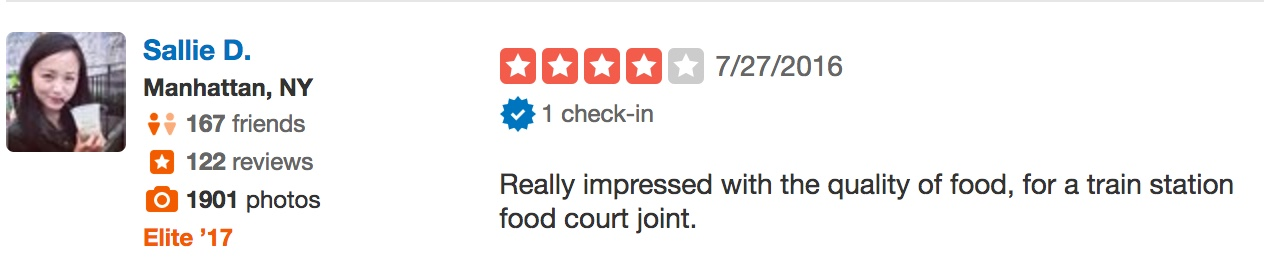

From:  https://www.yelp.com/biz/oath-craft-pizza-boston


In [7]:
from IPython.display import Image, display
display(Image(filename='Rating Demo.jpeg'))
print 'From: ', 'https://www.yelp.com/biz/oath-craft-pizza-boston'

In [8]:
review = pd.read_csv("yelp_academic_dataset_review.csv",delimiter=",")
review.head(3)

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
2  5UmKMjUEUNdYWqANhGckJw            1      5  2015-10-31  review   

   votes.useful  
0             0  
1             0  
2             1

**Summary**

In [9]:
print "number of reviews: ", review.shape[0]
print "number of business: ", review["business_id"].unique().shape[0]
print "average reviews per business: ", review.shape[0] / review["business_id"].unique().shape[0]
print 'Rating Scale: ',review.stars.unique()

number of reviews:  2685066
number of business:  85539
average reviews per business:  31
Rating Scale:  [4 5 3 2 1]


In [10]:
#order all business by number of ratings
num_review = review["business_id"].value_counts()
num_review_tuple = zip(num_review.index,num_review)

## Analysis & Visualization

### BSSM Model

$$
\left\{
        \begin{array}{ll}
          \theta_t = \theta_{t-1} + \epsilon_t\\
          p(\theta_t) = \frac{e^{\theta_t}}{1 + e^{\theta_t}}\\
          p(\textbf{y}_t\mid \theta_t,H_t) = \prod\limits_{i = 1}^{M} \binom{5}{y_{ti}} p(\theta_t)^{y_{ti}}(1 - p(\theta_t))^{5 - y_{ti}}
        \end{array}
\right.
$$

In [49]:
#input: 
#sigma (Float): unknow parameter
#N (Int): Rating Scale e.g. 5 stars
#M (List): Number of observations at a certain point
#R (List): Total ratings at a certain point
#output:
#theta_f (List): Mean of every latent variable
#sigma_f (List): Variance of every latent variable

def filtering(sigma,N,M,R):
    
    T = len(M)# Number of history 
    theta_i = 0 #initiate theta_0
    sigma_i = 0 #initiate signma_0
    p_i = 0.5
    theta_f = [theta_i]
    sigma_f = [sigma_i]
    p_f = [p_i]
    
    #iterate to calculate theta_f and sigma_f
    for i in range(T):
       
        sigma_i = 1/(M[i]*N*np.exp(theta_i)/(1+np.exp(theta_i))**2 + 1/(sigma_i + sigma)) #update sigma_i
        theta_i = theta_i + sigma_i * (R[i] - M[i] * N * p_i)
        p_i = np.exp(theta_i)/(1+np.exp(theta_i)) 
        
        theta_f.append(theta_i)
        sigma_f.append(sigma_i)
        p_f.append(p_i)
        
    return theta_f,sigma_f,p_f

def smoothing(sigma, N, M, R):
    
    theta_f,sigma_f,_ = filtering(sigma,N,M,R)
    
    T = len(M)# Number of history
    theta_i = theta_f[-1] #initiate theta_0
    sigma_i = sigma_f[-1] #initiate signma_0
    theta_s = [theta_i]
    sigma_s = [sigma_i]
    
    for i in range(T):
        A = sigma_f[T-i-1]/(sigma_f[T-i-1] + sigma)
        theta_i = theta_f[T-i-1] + A * (theta_i - theta_f[T-i-1])
        sigma_i = sigma_f[T-i-1] + A * (sigma_i - sigma_f[T-i-1])
        
        theta_s.append(theta_i)
        sigma_s.append(sigma_i)
        
        
    return theta_s[::-1], sigma_s[::-1], theta_f, sigma_f 

def EM(sigma0, N, M, R):
    
    T = len(M)# Number of history
    sigma_old = 1000000
    sigma_new = sigma0
    n = 0
    p_lows = [] #skip the initial value 0 for plotting
    p_highs = []

    while (abs(sigma_old - sigma_new) > 0.00001):
        
        n += 1 
        sigma_old = sigma_new
        
        theta_s, sigma_s, theta_f, sigma_f  = smoothing(sigma_old, N, M, R)
        W_k = np.square(theta_s) + sigma_s 
        W_kk_1 = [(sigma_f[i]/(sigma_f[i] + sigma_old) * sigma_s[i+1] + theta_s[i] * theta_s[i+1]) for i in range(T)]
        sigma_new = (2 * np.sum(W_k) - W_k[0] - W_k[-1])/ T - 2 * np.mean(W_kk_1)
    
    
    #get best estimate of mean and variance of the latent variables
    theta_EM,sigma_EM,p_EM = filtering(sigma_new,N,M,R)

    for theta, sigma in zip(theta_EM,sigma_EM)[1:]: #skip the initial values (0,0)
        
        samples = np.random.normal(theta, sigma, 10000)
        ps = map(lambda x: np.exp(x)/(1 + np.exp(x)),samples)
        p_low, p_high = np.percentile(ps,[2.5,97.5])
        p_lows.append(p_low)
        p_highs.append(p_high)
    
    return p_EM[1:], p_lows, p_highs

In [245]:
kw = lambda x: x.isocalendar()[1]
class Restuarant:
    #initiate datasets
    def __init__(self, ID, busi_data, review_data):
        self.business = busi_data
        self.review = review_data
        self.ID = ID
        self.name = self.business[self.business["business_id"] == self.ID]["name"].values[0]
        self.target =  self.review[self.review["business_id"] == ID][["stars","date"]]
        self.target["year"] = self.target["date"].str.split("-").str[0]
        self.target["month"] = self.target["date"].str.split("-").str[1]
        self.target["day"] = self.target["date"].str.split("-").str[2]
        self.target["year_month"] = self.target["date"].str.rsplit("-", n=1).str[0]
        
        #add week info
        self.target['week'] = pd.to_datetime(res.target['date'], format = '%Y-%m-%d').map(kw).apply(str)
        self.target["year_week"] = self.target["year"].map(str) + self.target["week"]
        
        self.xformat_y_m = mdates.DateFormatter('%Y-%m') #format 1994-03
        self.xformat_y_d = mdates.DateFormatter('%Y-%m-%d')#format 1994-03-01
        
    #find whole name of a restuarant by matching partial str
    def find_res_by_name(self, name):
        matched_res_index = self.business['name'].str.contains(name)
        self.find_by_match = self.business[matched_res_index][['name','business_id']]
        return self.find_by_match

    def reviews_year_month (self):
       
        self.target_review_year_month = self.target[["year_month","day","year","month"]].groupby("year_month").agg({"day": lambda x: x.shape[0],
                                "year": lambda x: x.values[0],
                                "month": lambda x: x.values[0]
                               }).apply(pd.to_numeric)
        
        self.target_review_year_month.rename(columns = {'day':'counts'}, inplace = True)
        
    def reviews_year_day (self):

        self.target_review_year_day = self.target[["date","day","year"]].groupby("date").agg({"day": lambda x: x.shape[0],
                                "year": lambda x: x.values[0],
                               }).apply(pd.to_numeric)
        
        self.target_review_year_day.rename(columns = {'day':'counts'}, inplace = True)
        
        #create full date dataframe
        full = pd.date_range(self.target_review_year_day.index[0], self.target_review_year_day.index[-1], freq='D')
        ts = pd.DataFrame({'copy': full},index = full)
        ts['year'] = [d.year for d in ts['copy']] #create a year column
        ts['n_day'] = [d.dayofyear for d in ts['copy']] #order of the day in a year
        ts['day'] = [float(str(d.month) + '.' + str(d.day)) for d in ts['copy']] #create a day column
        
        #merge to get full date dataframe
        merged = pd.merge(ts,self.target_review_year_day,how = 'outer', on = ['year'],left_index=True,right_index = True)
        merged.drop('copy',axis = 1,inplace=True)
        merged.fillna(0,inplace=True)
        
       
        merged.loc[merged['counts'] >1, 'counts'] = 1 #ratings >=1 to be 1
        self.target_review_year_day = merged[merged['counts']!=0] #
        
    def reviews_date (self):

        self.target_review_date = self.target[["date","day","year","stars"]].groupby("date").agg({"day": lambda x: x.shape[0],
                                "year": lambda x: x.values[0],"stars": lambda x: x.sum()
                               }).apply(pd.to_numeric)
        
        self.target_review_date.rename(columns = {'day':'counts'}, inplace = True)
        
        #create full date dataframe
        full = pd.date_range(self.target_review_date.index[0], self.target_review_date.index[-1], freq='D')
        ts = pd.DataFrame({'copy': full},index = full)
        ts['year'] = [d.year for d in ts['copy']] #create a year column
        ts['n_day'] = [d.dayofyear for d in ts['copy']] #order of the day in a year
        ts['day'] = [float(str(d.month) + '.' + str(d.day)) for d in ts['copy']] #create a day column
        
        #merge to get full date dataframe
        merged = pd.merge(ts,self.target_review_date,how = 'outer', on = ['year'],left_index=True,right_index = True)
        merged.drop('copy',axis = 1,inplace=True)
        merged.fillna(0,inplace=True)
        
        self.target_review_date = merged[merged['counts']!=0] #  
        
    def reviews_month (self):

        self.target_review_month = self.target[["year_month","day","year","month","stars"]].groupby("year_month").agg({"day": lambda x: x.shape[0],
                                "year": lambda x: x.values[0],
                                "month": lambda x: x.values[0],
                                 "stars": lambda x: x.sum()                                                                                        
                               }).apply(pd.to_numeric)
        
        self.target_review_month.rename(columns = {'day':'counts'}, inplace = True) 
        
    def reviews_week (self):

        self.target_review_week = self.target[["year_week","day","stars"]].groupby("year_week").agg({"day": lambda x: x.shape[0],
                               
                                 "stars": lambda x: x.sum()                                                                                        
                               }).apply(pd.to_numeric)
        
        self.target_review_week.rename(columns = {'day':'counts'}, inplace = True)  


    def plot_reviews (self):
        print self.name
        
        years =  self.target_review_year_month["year"].unique()
        
        date = self.target_review_month.index
        self.xtick_y_m = [DT.datetime.strptime(day,'%Y-%m') for day in date]
        
        self.xtick_y_d = self.target_review_date.index
        #self.xtick_y_w = [DT.datetime.strptime(day,'%Y%m') for day in self.target_review_week.index]
        #self.xtick_y_d = [DT.datetime.strptime(day,'%Y-%m-%d') for day in date]

        #plot number of total ratings by year
        fig,ax = plt.subplots(2,2,figsize = (20,10))
        ax[0][0].plot(self.xtick_y_m, self.target_review_year_month['counts'])
        ax[0][0].set_title('Number of Ratings by Month',fontsize=20)
        ax[0][0].set_ylabel('Number of ratings',fontsize=15)
        ax[0][0].set_xlabel('Month',fontsize=15)
        ax[0][0].xaxis.set_major_formatter(self.xformat_y_m)

#         for year in years:
#             reviews_by_year = self.target_review_year_month[self.target_review_year_month["year"] == year]
#             ax[0][1].plot(reviews_by_year["month"] ,reviews_by_year['counts'],label = year, marker = "+")

#         #plot number of ratings by year and month
#         ax[0][1].legend(bbox_to_anchor=(1.3, 1.0))
#         ax[0][1].set_xlabel("month")
#         ax[0][1].set_xlim(1,12)
#         ax[0][1].set_ylabel("number of ratings")
#         ax[0][1].set_title(self.name,fontsize=20)
        
        #plot ratings by month
        total_stars = self.target_review_month['stars'].values
        number_rating = self.target_review_month['counts'].values
        rating_scale = 5
        
        p,p_low,p_up = EM(0.001,rating_scale,number_rating,total_stars)
        
        line_1, = ax[0][1].plot(self.xtick_y_m,p,c = 'b',label = 'BSSM_p') #estimated hidden state
        simple_p = total_stars / (number_rating * 5.)
        #line_2, = ax[0][1].plot(self.xtick_y_m,simple_p,c = 'r',label = 'Simple_p',alpha = 0.6) #from the data
        ax[0][1].fill_between(self.xtick_y_m,p_low,p_up,color='blue',alpha=0.2)
        blue_patch = mpatches.Patch(color='blue', alpha = 0.4,label='Uncertainty')
        #ax[0][1].legend(loc = 4,handles=[line_2,line_1, blue_patch])
        ax[0][1].legend(loc = 4,handles=[line_1, blue_patch])
        
        
        ax[0][1].set_ylim(0,1)
        ax[0][1].set_ylabel('Estimated Likeability',fontsize=15)
        ax[0][1].set_xlabel('Month',fontsize=20)
        ax[0][1].xaxis.set_major_formatter(self.xformat_y_m)
        ax[0][1].set_title('Estimated Likeability by Month',fontsize=20)
        
#         #plot ratings by day
#         total_stars = self.target_review_date['stars'].values
#         number_rating = self.target_review_date['counts'].values
#         rating_scale = 5
        
#         p,p_low,p_up = EM(0.001,rating_scale,number_rating,total_stars)
        
#         line_1, = ax[1][1].plot(self.xtick_y_d,p,c = 'b',label = 'BSSM_p') #estimated hidden state
#         simple_p = total_stars / (number_rating * 5.)
#         line_2, = ax[1][1].plot(self.xtick_y_d,simple_p,c = 'r',label = 'Simple_p',alpha = 0.6) #from the data
#         ax[1][1].fill_between(self.xtick_y_d,p_low,p_up,color='blue',alpha=0.2)
#         blue_patch = mpatches.Patch(color='blue', alpha = 0.4,label='Uncertainty')
#         ax[1][1].legend(loc = 4,handles=[line_2,line_1, blue_patch])
#         #ax[1][1].legend(loc = 4,handles=[line_1, blue_patch])
        
        
#         ax[1][1].set_ylim(0,1)
#         ax[1][1].set_ylabel('Estimated Likeability',fontsize=15)
#         ax[1][1].set_xlabel('Day',fontsize=20)
#         ax[1][1].xaxis.set_major_formatter(self.xformat_y_d)
#         ax[1][1].set_title('Estimated Likeability by Day',fontsize=20)
        
       
        
        
        #plot ratings by week
        total_stars = self.target_review_week['stars'].values
        number_rating = self.target_review_week['counts'].values
        rating_scale = 5
        
        p,p_low,p_up = EM(0.001,rating_scale,number_rating,total_stars)
        
        line_1, = ax[1][1].plot(range(len(p)),p,c = 'b',label = 'BSSM_p') #estimated hidden state
        simple_p = total_stars / (number_rating * 5.)
        #line_2, = ax[1][1].plot(range(len(p)),simple_p,c = 'r',label = 'Simple_p',alpha = 0.6) #from the data
        ax[1][1].fill_between(range(len(p)),p_low,p_up,color='blue',alpha=0.2)
        blue_patch = mpatches.Patch(color='blue', alpha = 0.4,label='Uncertainty')
        #ax[1][1].legend(loc = 4,handles=[line_2,line_1, blue_patch])
        ax[1][1].legend(loc = 4,handles=[line_1, blue_patch])
        ax[1][1].set_ylim(0,1)
        ax[1][1].set_ylabel('Estimated Likeability',fontsize=15)
        ax[1][1].set_xlabel('Week',fontsize=20)
        #ax[1][1].xaxis.set_major_formatter(self.xformat_y_m)
        ax[1][1].set_title('Estimated Likeability by Week',fontsize=20)
        
        
         #week counts
        ax[1][0].plot(range(len(p)), self.target_review_week['counts'])
        ax[1][0].set_title('Number of Ratings by Week',fontsize=20)
        ax[1][0].set_ylabel('Number of ratings',fontsize=15)
        ax[1][0].set_xlabel('Week',fontsize=15)
        #ax[1][0].xaxis.set_major_formatter(self.xformat_y_m)
        
        
      
#         ax[1][1].set_ylabel('Estimated Likeability',fontsize=15)
#         ax[1][1].set_xlabel('Day',fontsize=20)
#         ax[1][1].xaxis.set_major_formatter(self.xformat_y_d)
#         ax[1][1].set_title('Estimated Likeability by Day',fontsize=20)
#         #plot rating or not by year and day
#         years =  self.target_review_year_day["year"].unique()
#         for year in years:
#             reviews_by_year = self.target_review_year_day[self.target_review_year_day["year"] == year]
#             ax[1][1].scatter(reviews_by_year["n_day"] ,reviews_by_year['year'], marker = ".",color = 'b',s=4)
#             ax[1][1].set_xlim(0,366)
            
        plt.show()

Mon Ami Gabi


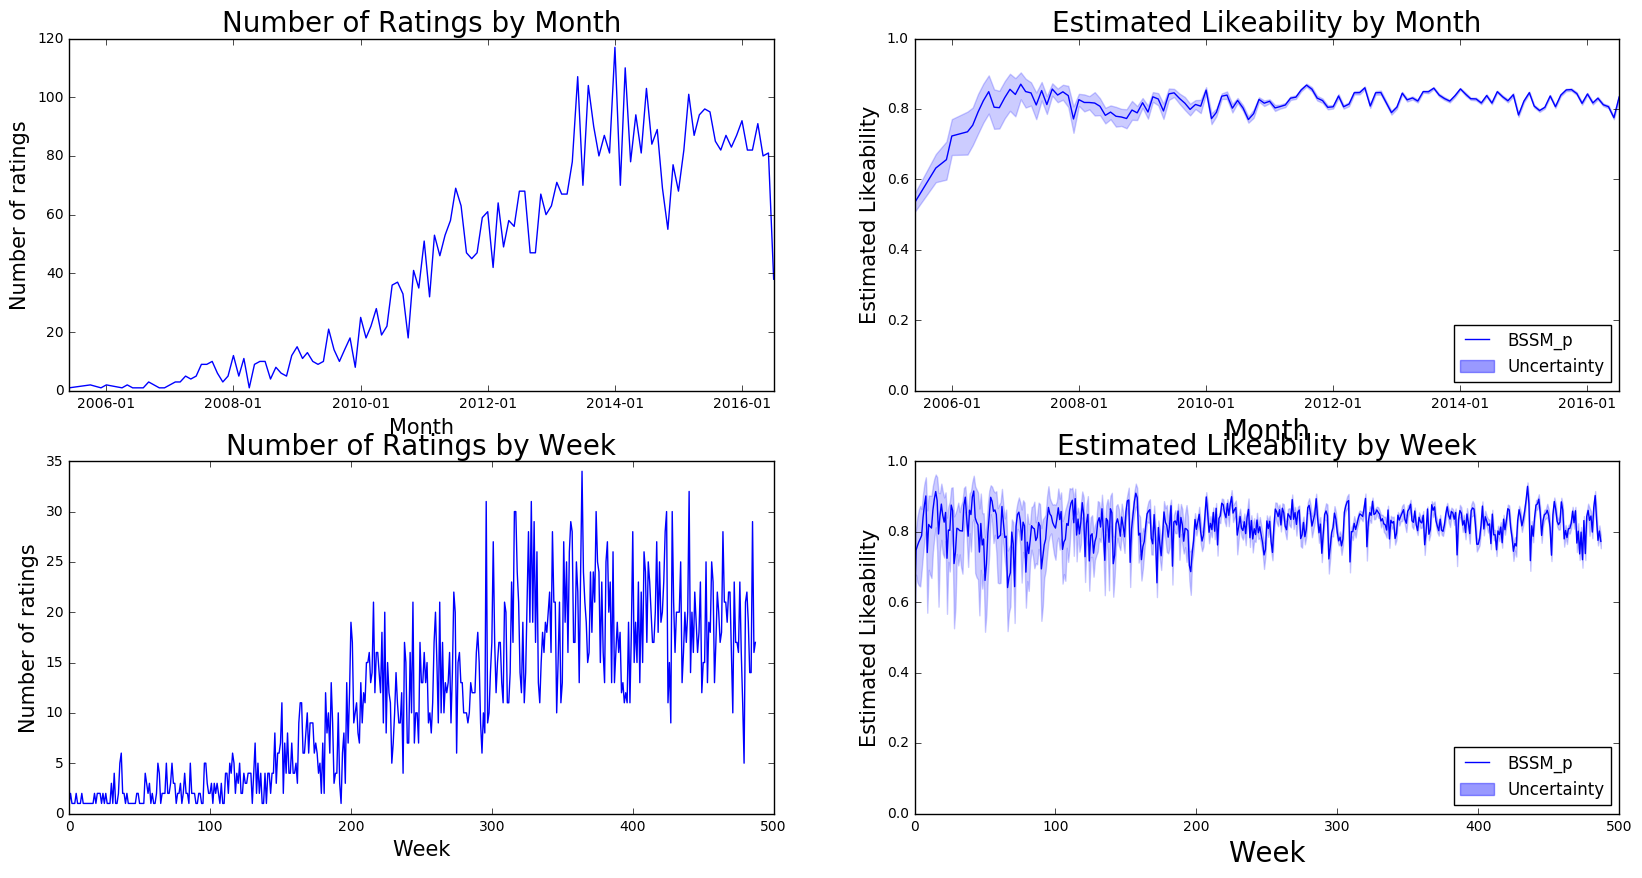

Bacchanal Buffet


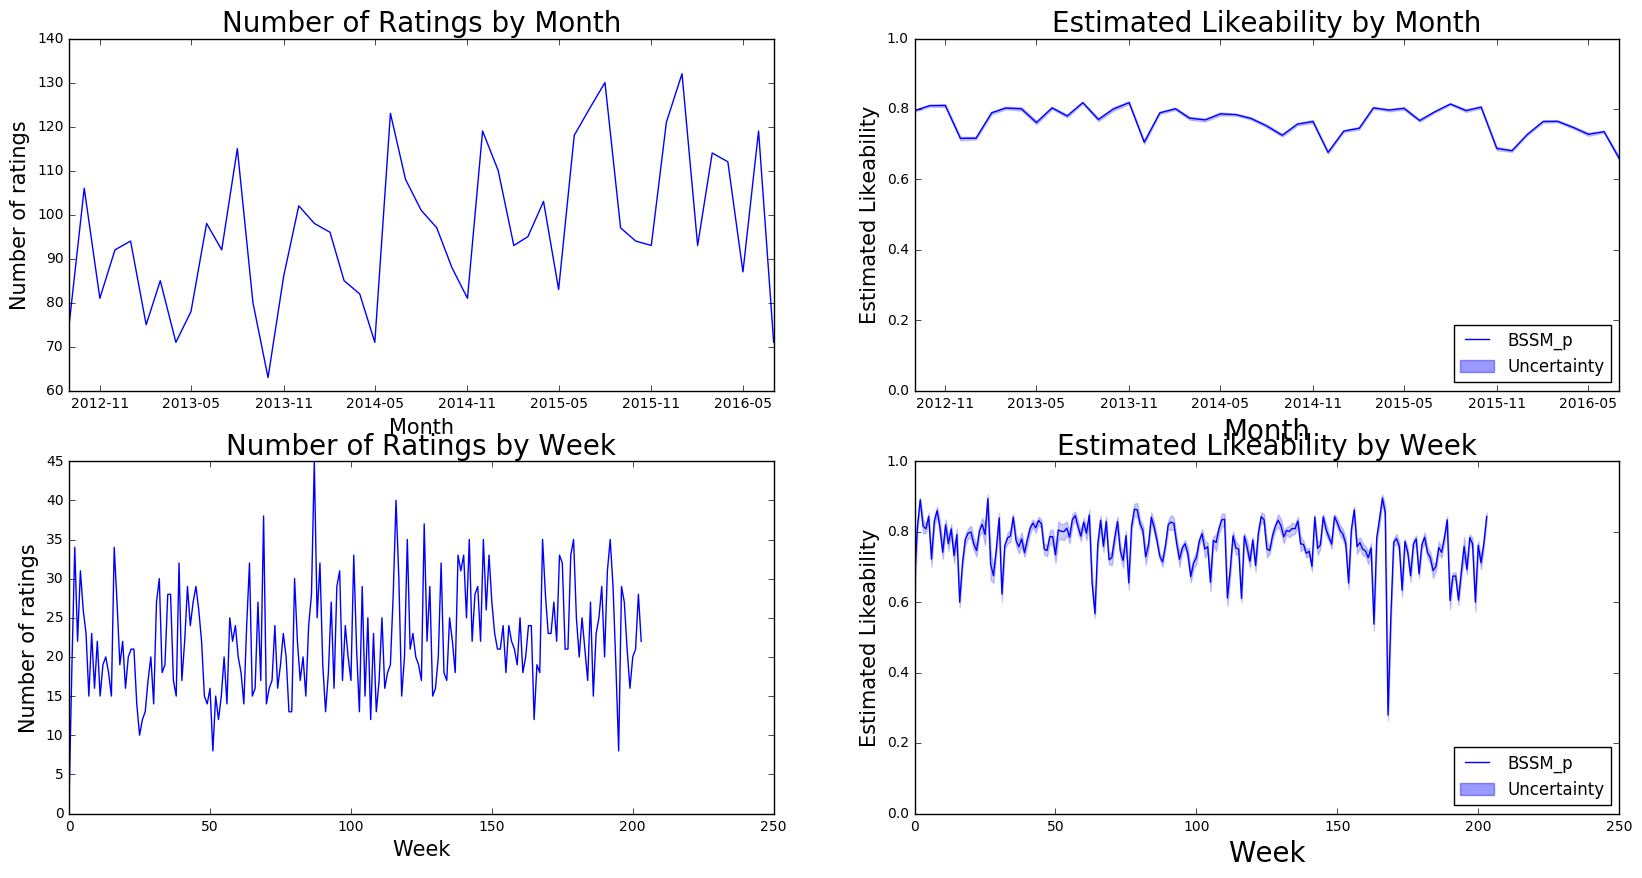

Wicked Spoon


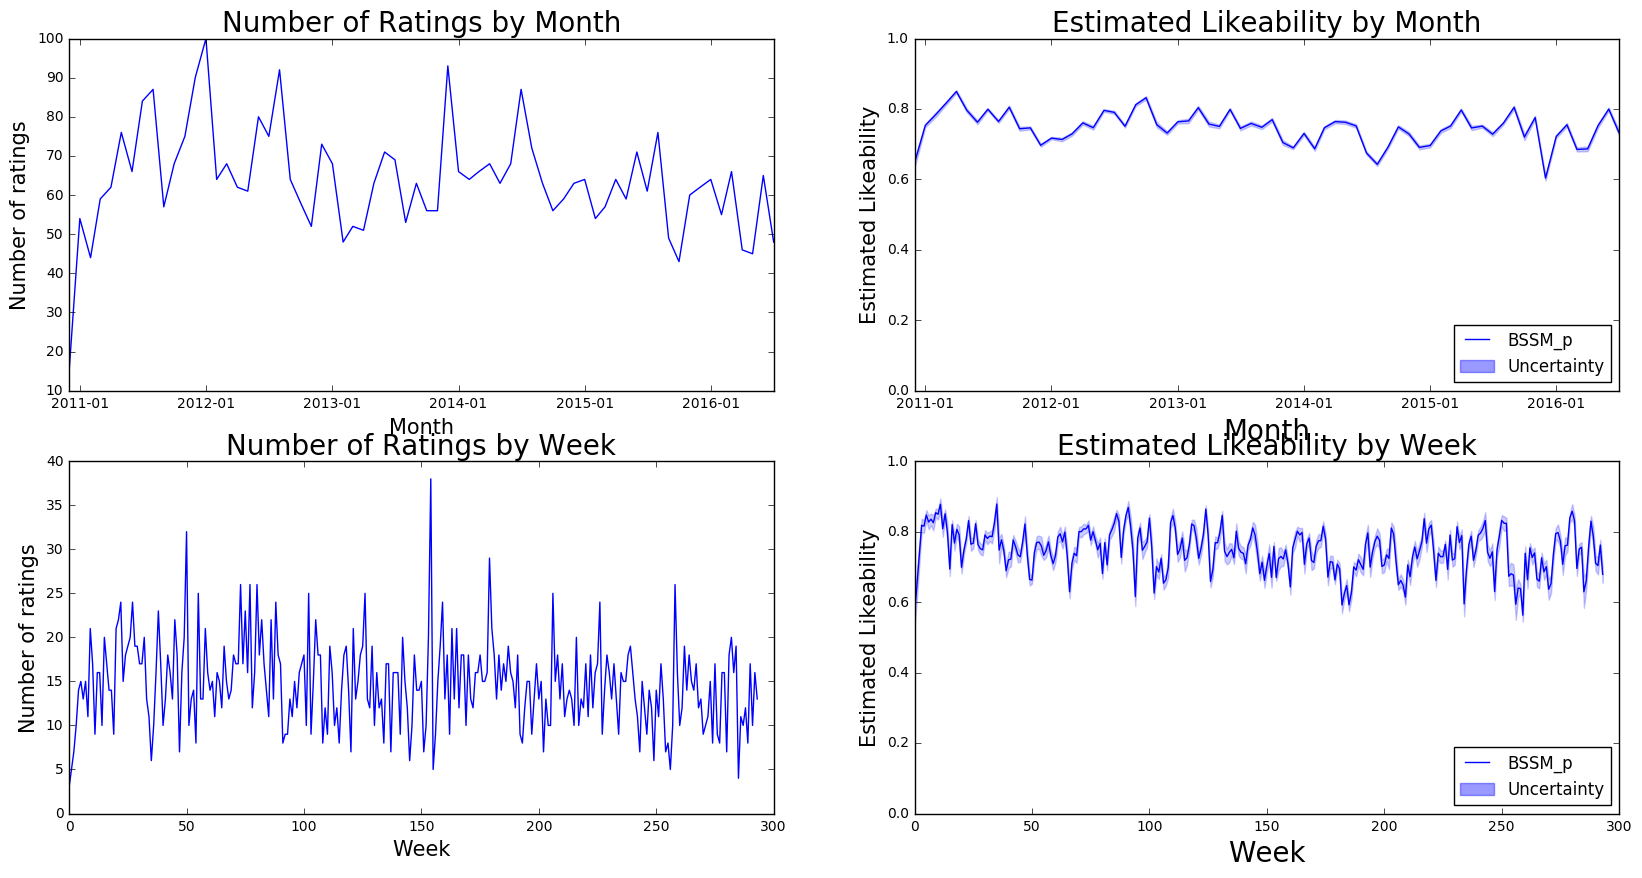

Gordon Ramsay BurGR


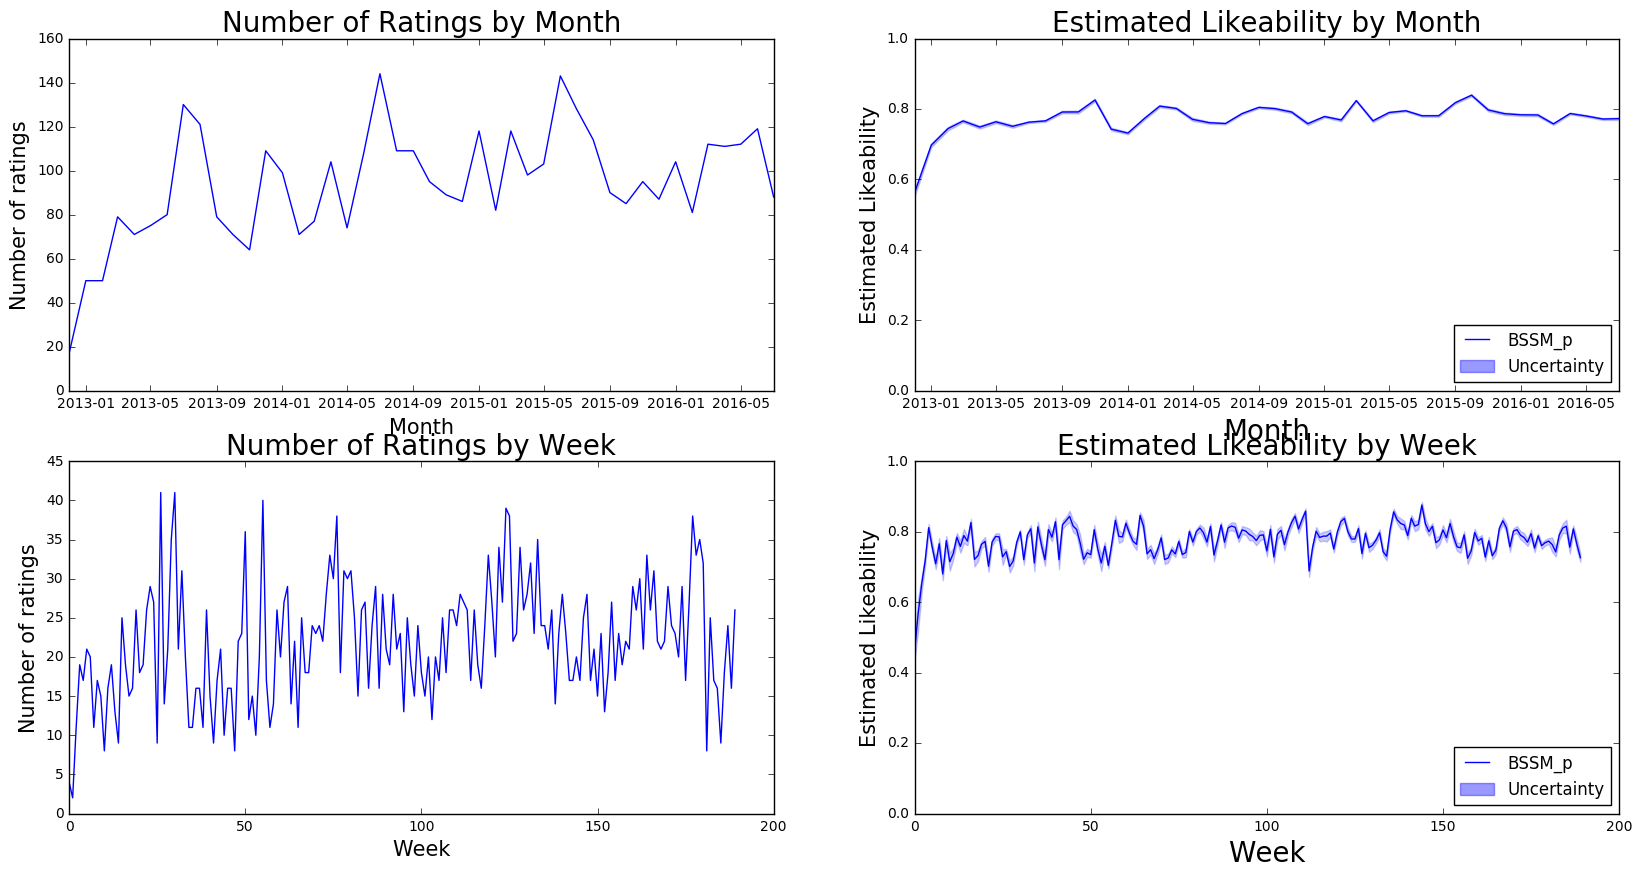

Earl of Sandwich


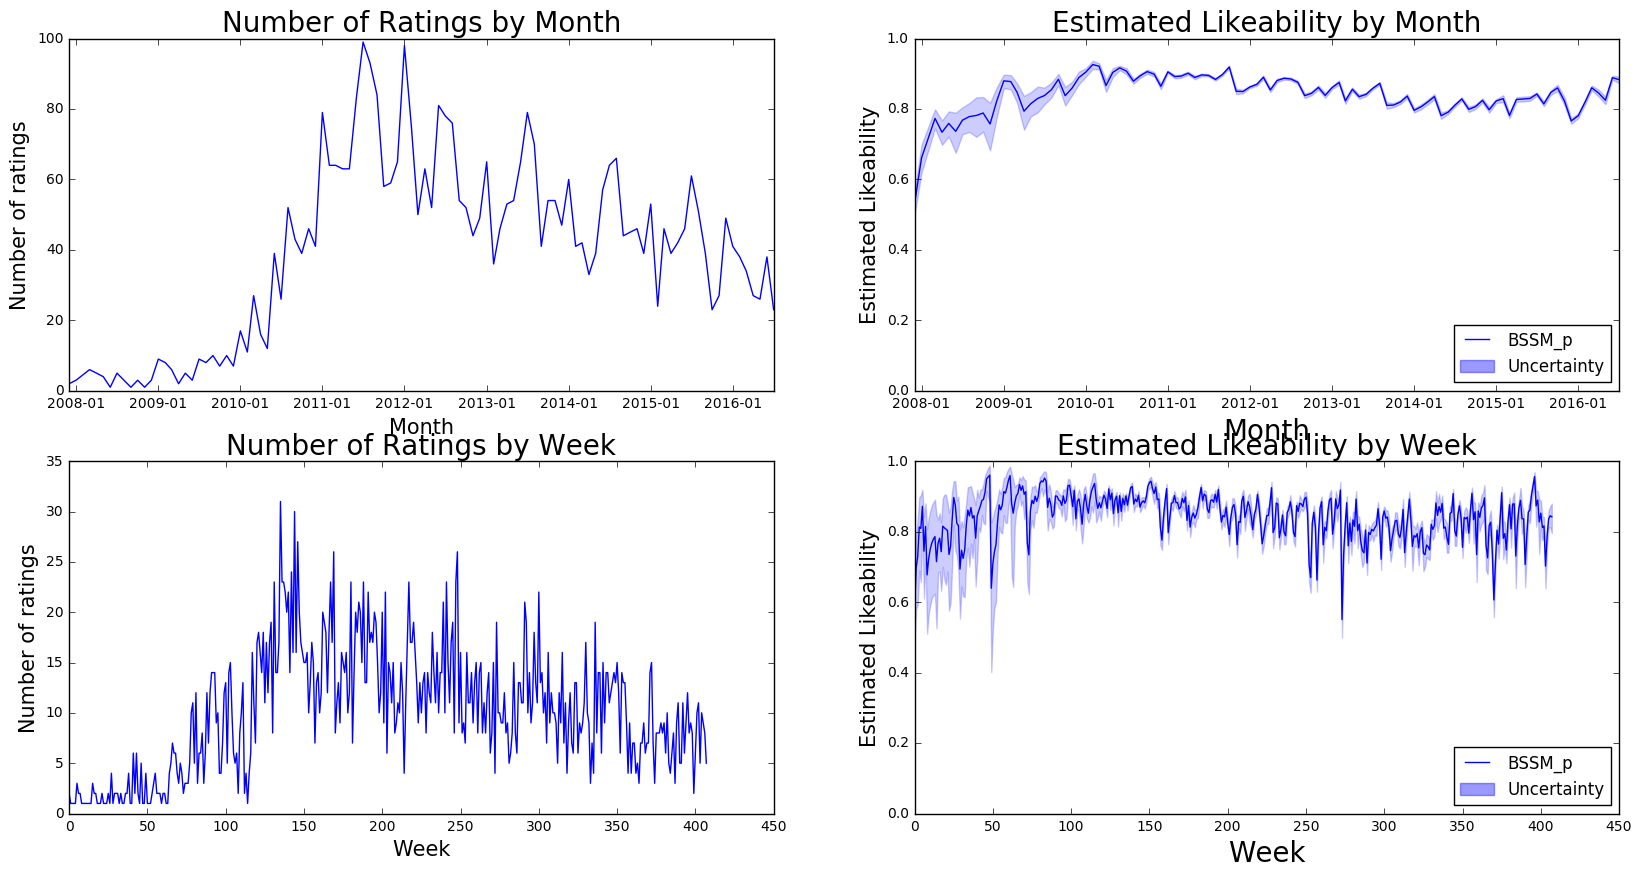

Gangnam Asian BBQ Dining


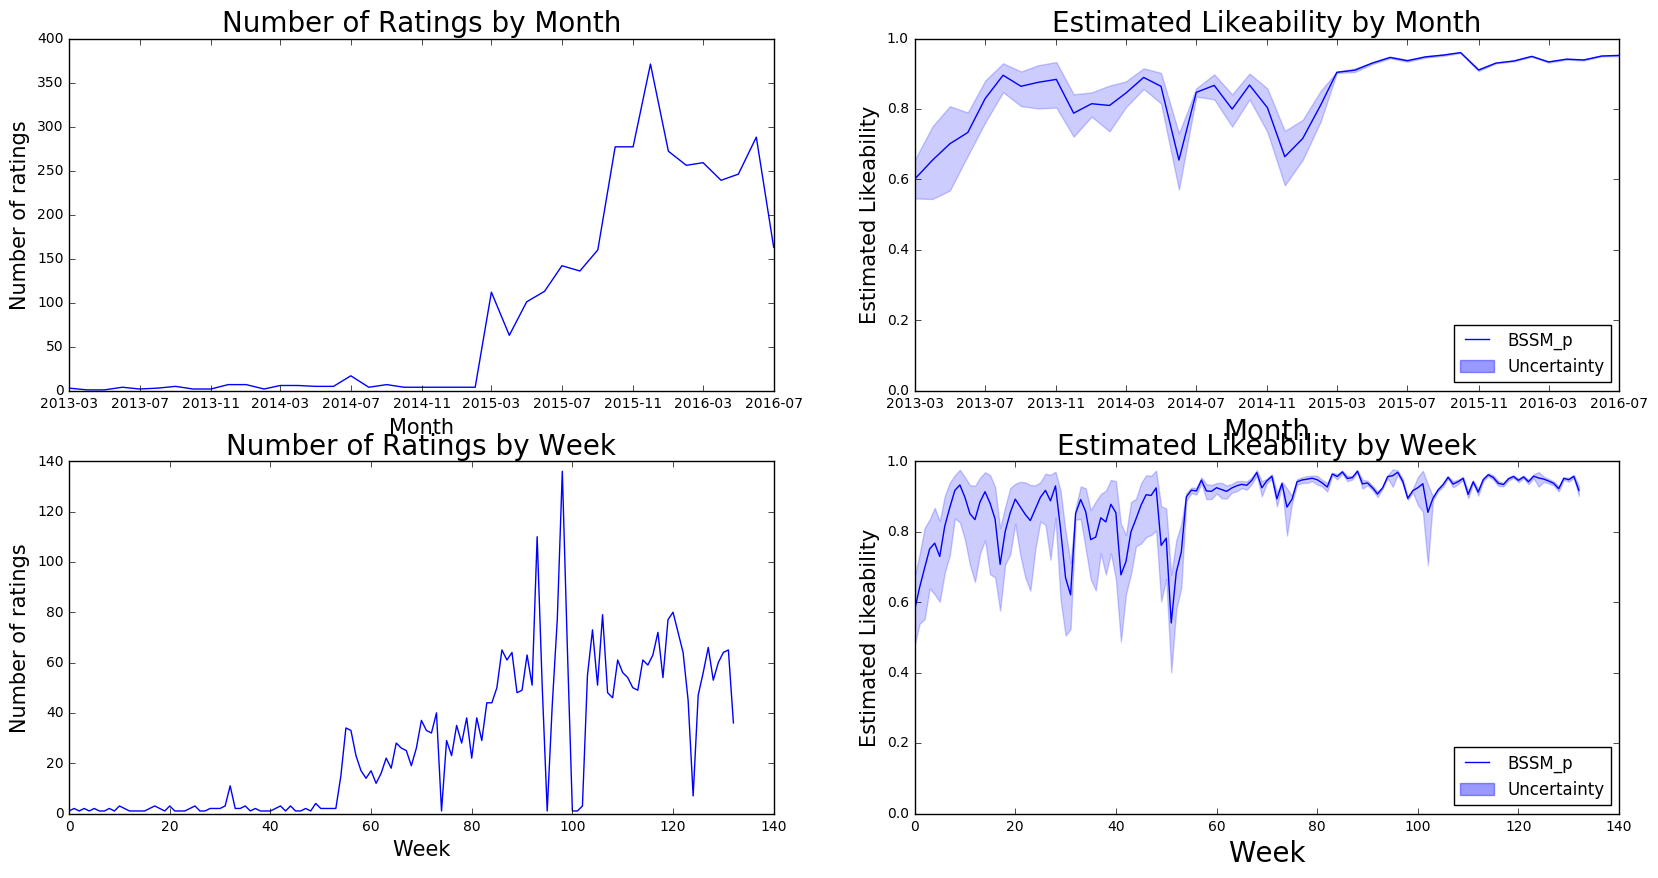

Serendipity 3


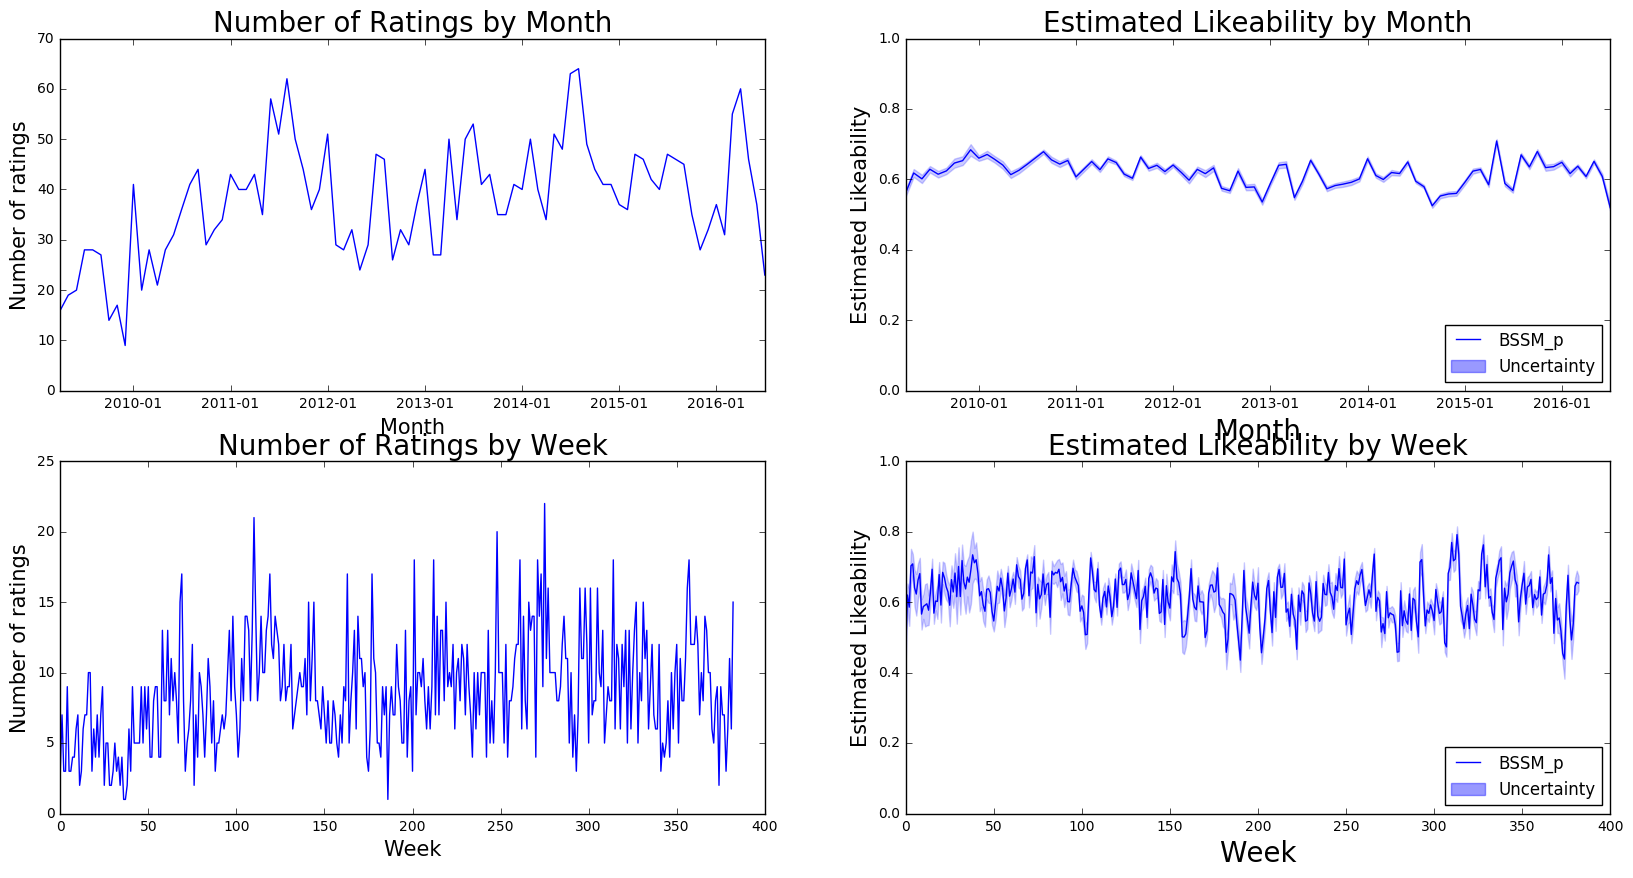

Hash House A Go Go


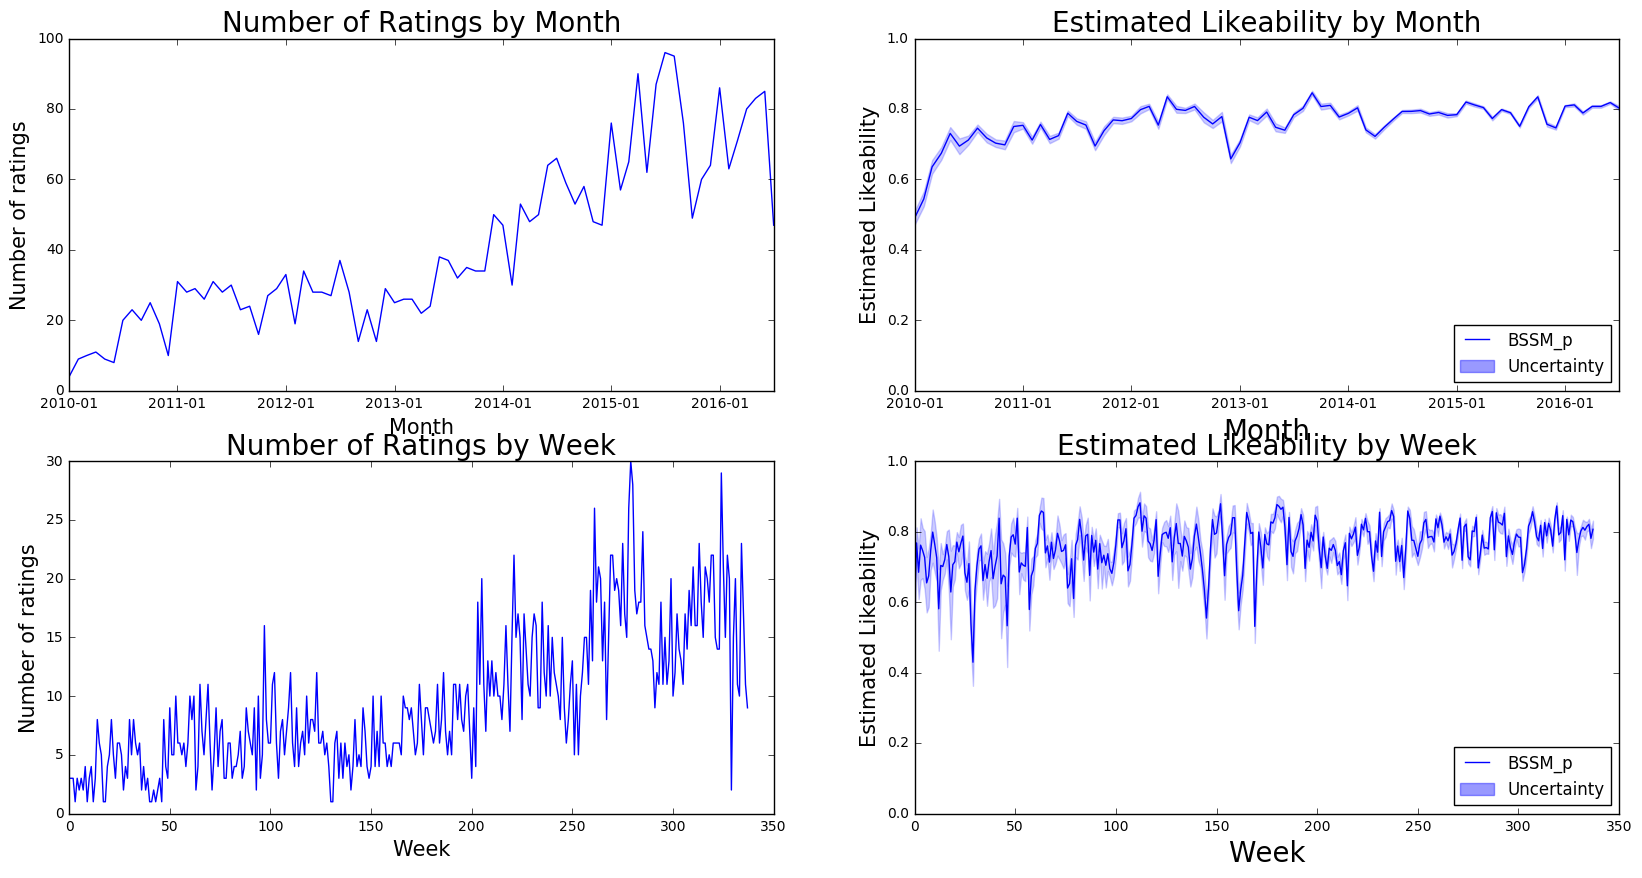

The Buffet


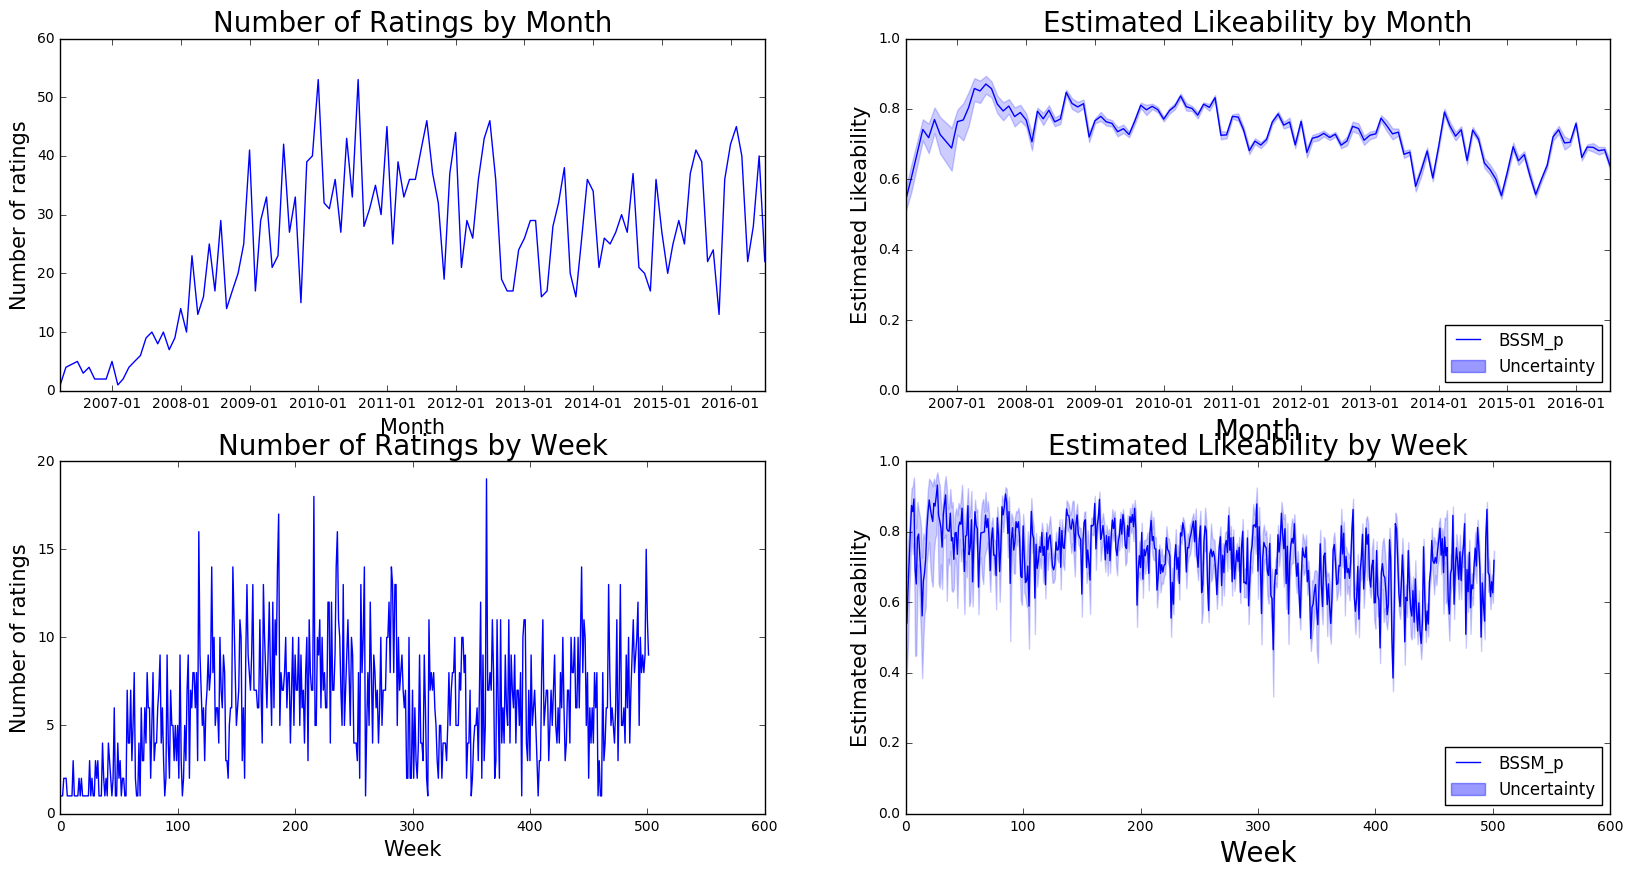

Lotus of Siam


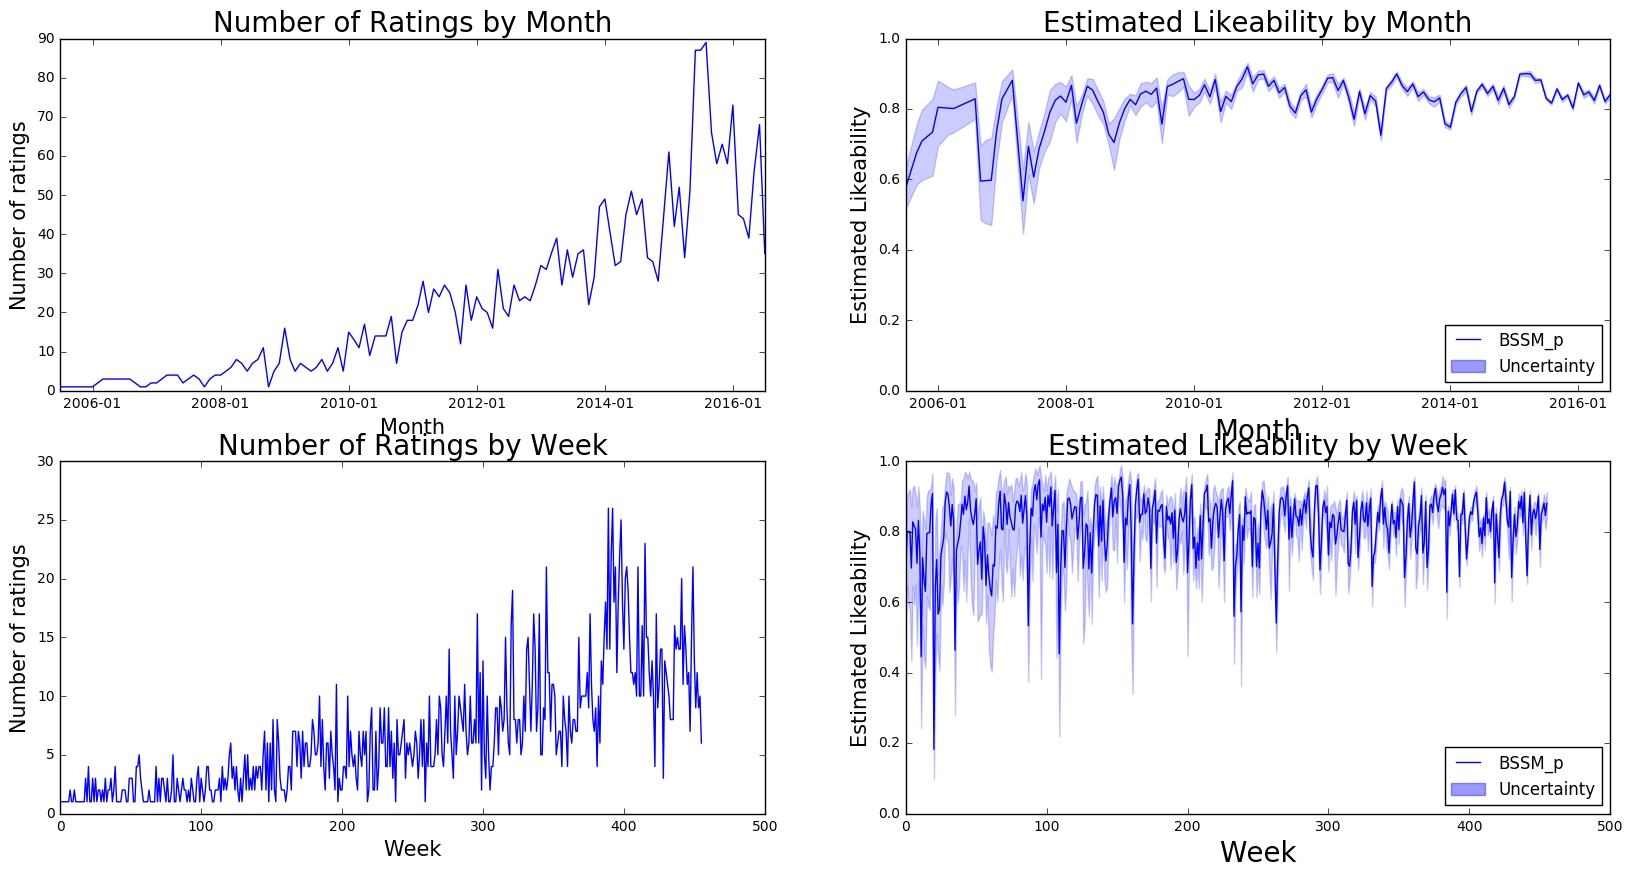

In [247]:
for i in range(10):
    ID = num_review_tuple[i][0]
    res = Restuarant(ID,business,review)
    res.reviews_year_month()
    res.reviews_year_day()
    res.reviews_date()
    res.reviews_month()
    res.target['week'] = pd.to_datetime(res.target['date'], format = '%Y-%m-%d').map(kw).apply(str)
    res.target["year_week"] = res.target["year"].map(str) + res.target["week"]
    res.reviews_week()
    res.plot_reviews()
#     reviews = nreviews_year_month(ID,review,business)
#     plot_reviews(reviews[0],reviews[1])

Mon Ami Gabi


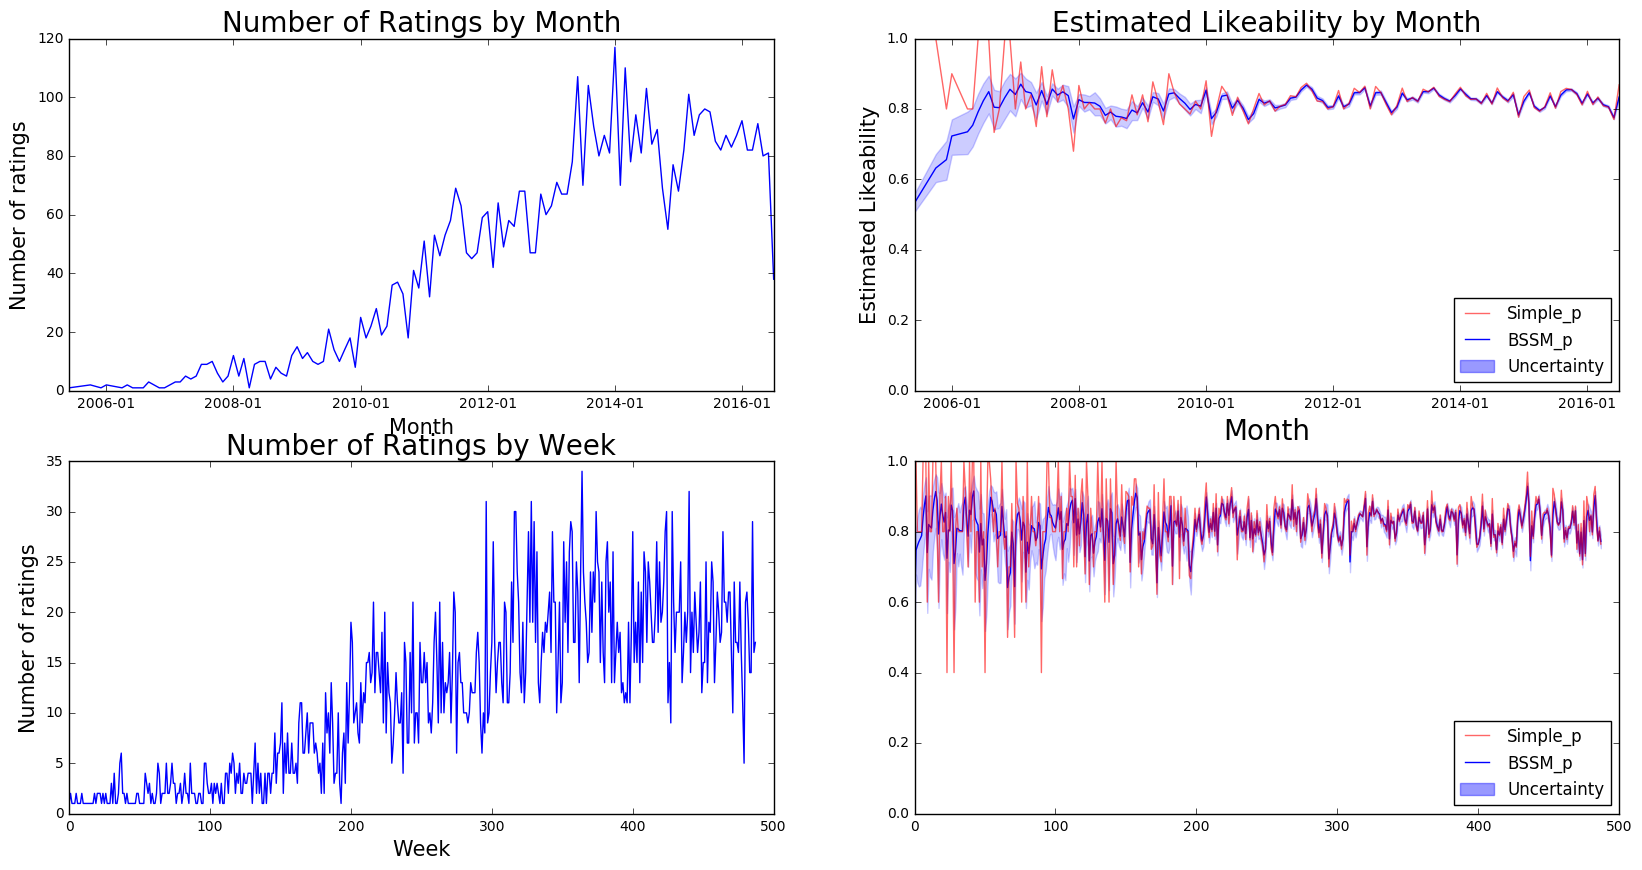

Bacchanal Buffet


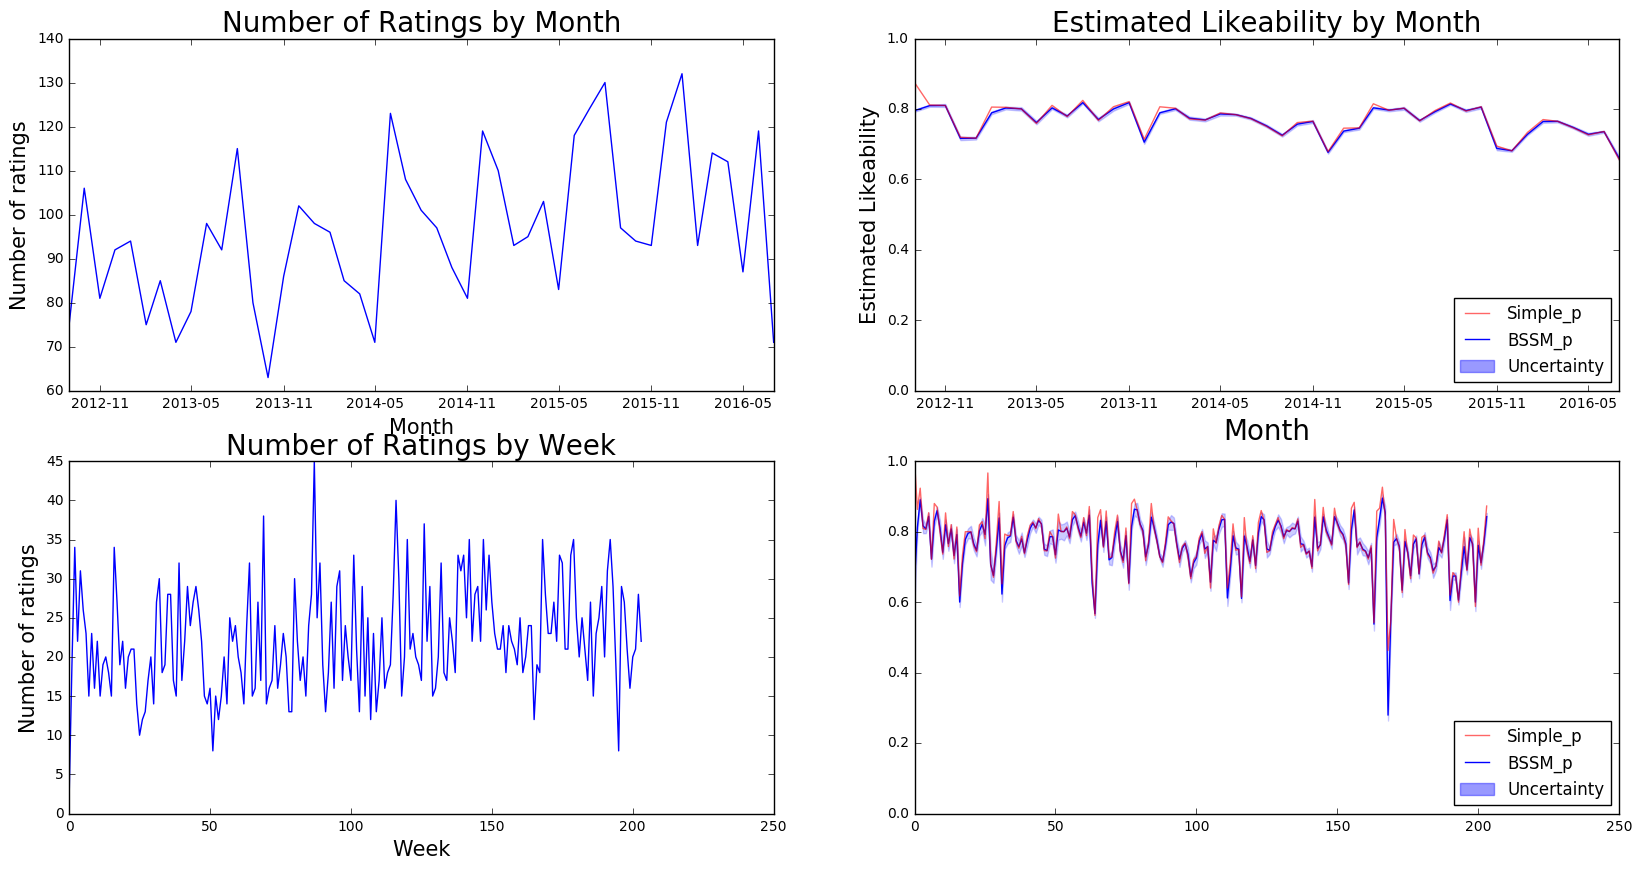

Wicked Spoon


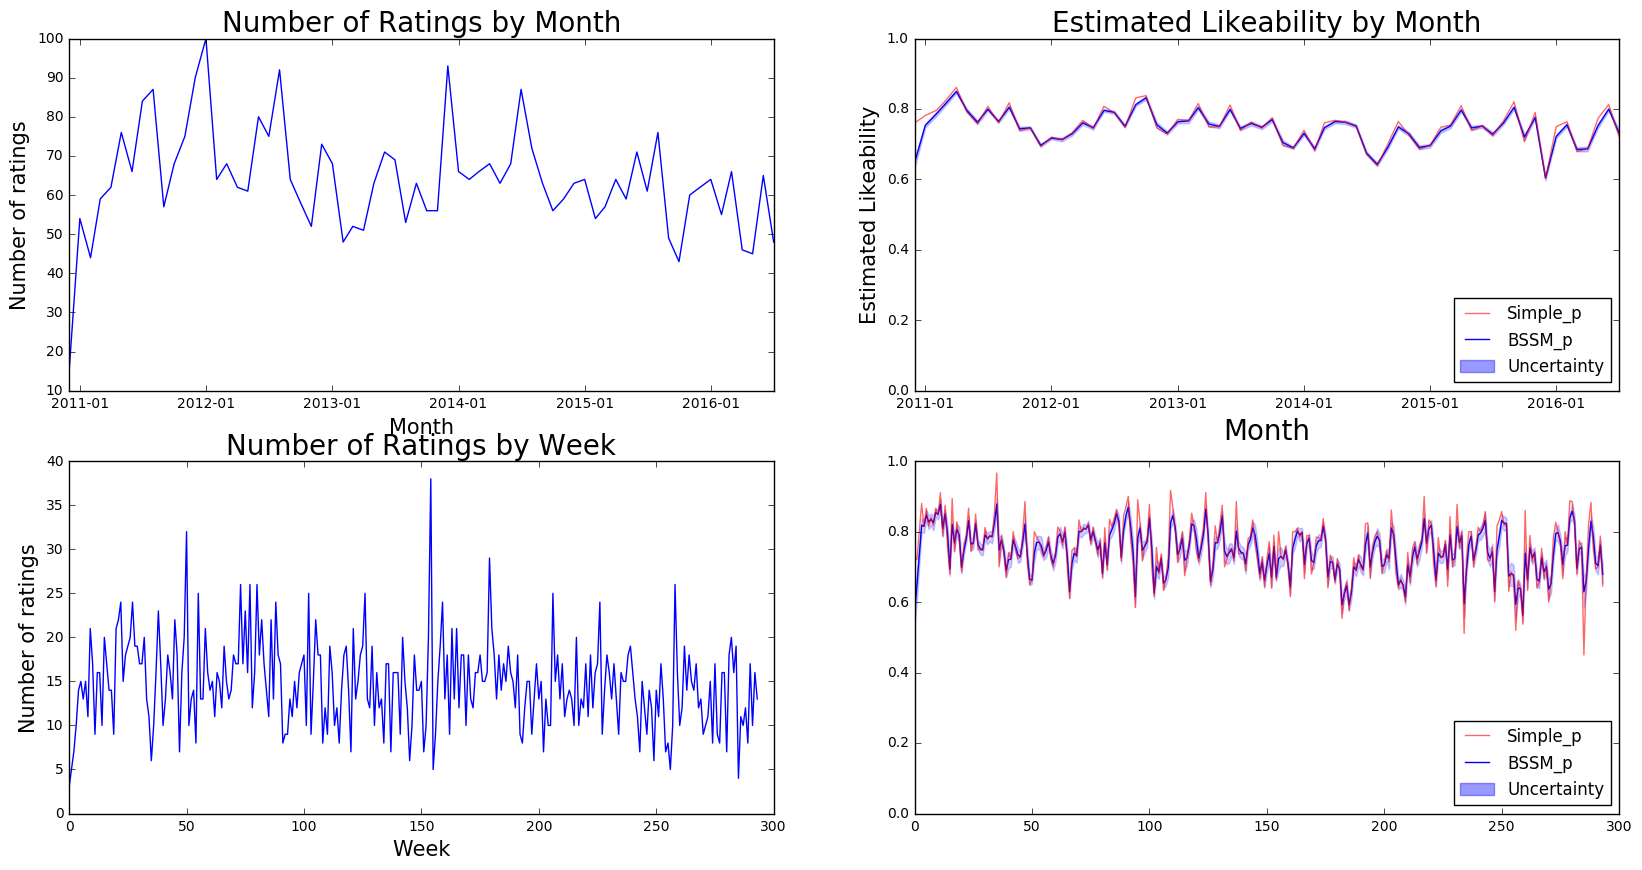

Gordon Ramsay BurGR


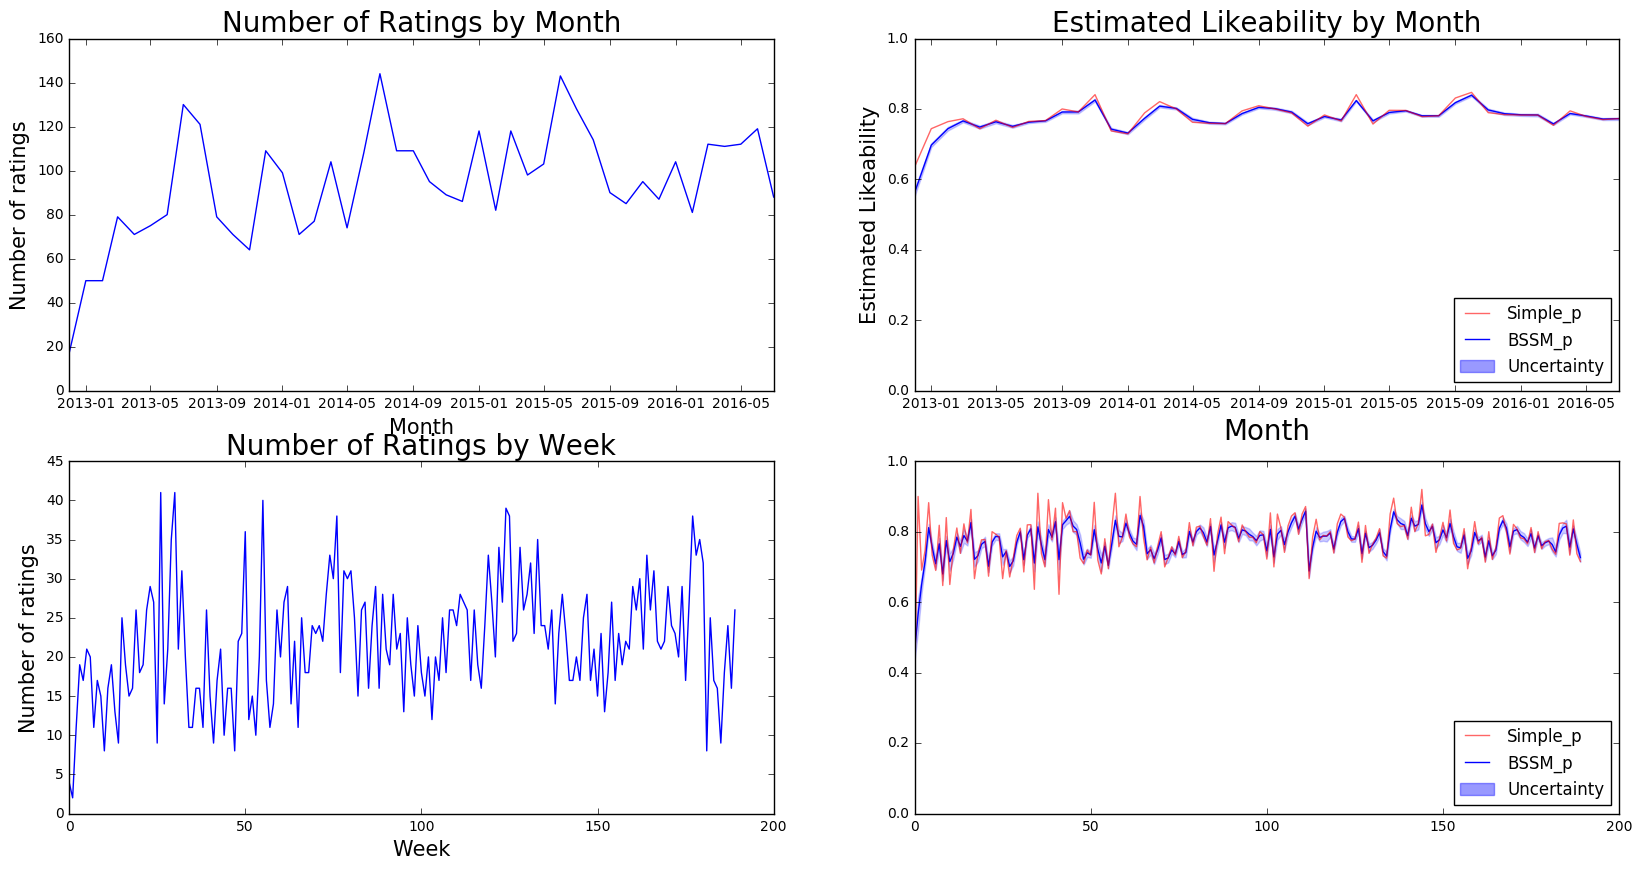

Earl of Sandwich


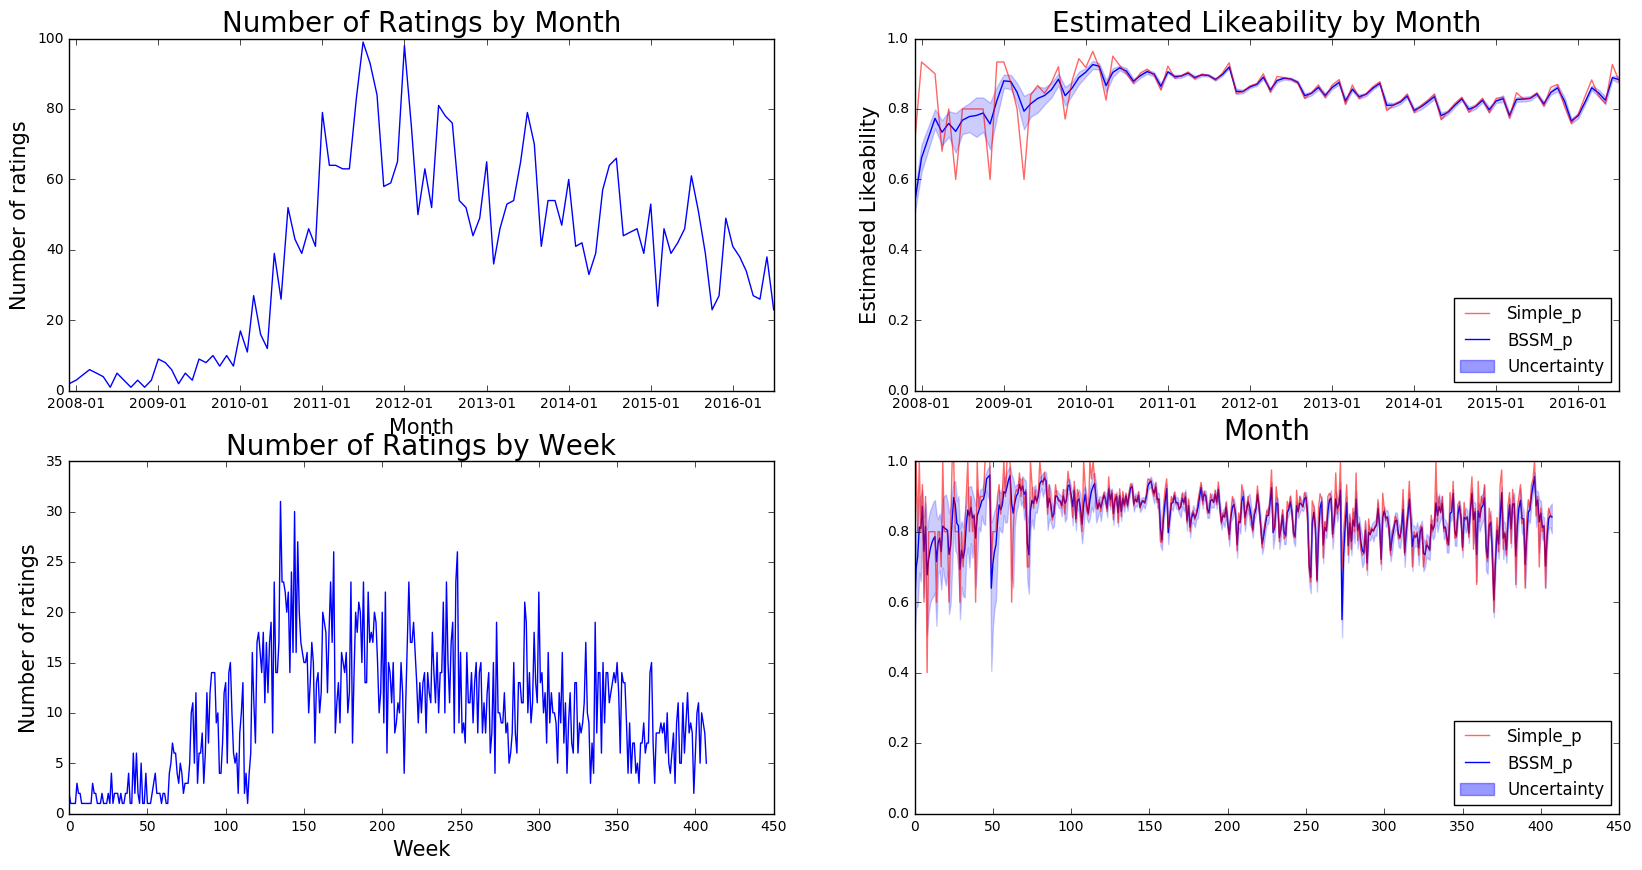

Gangnam Asian BBQ Dining


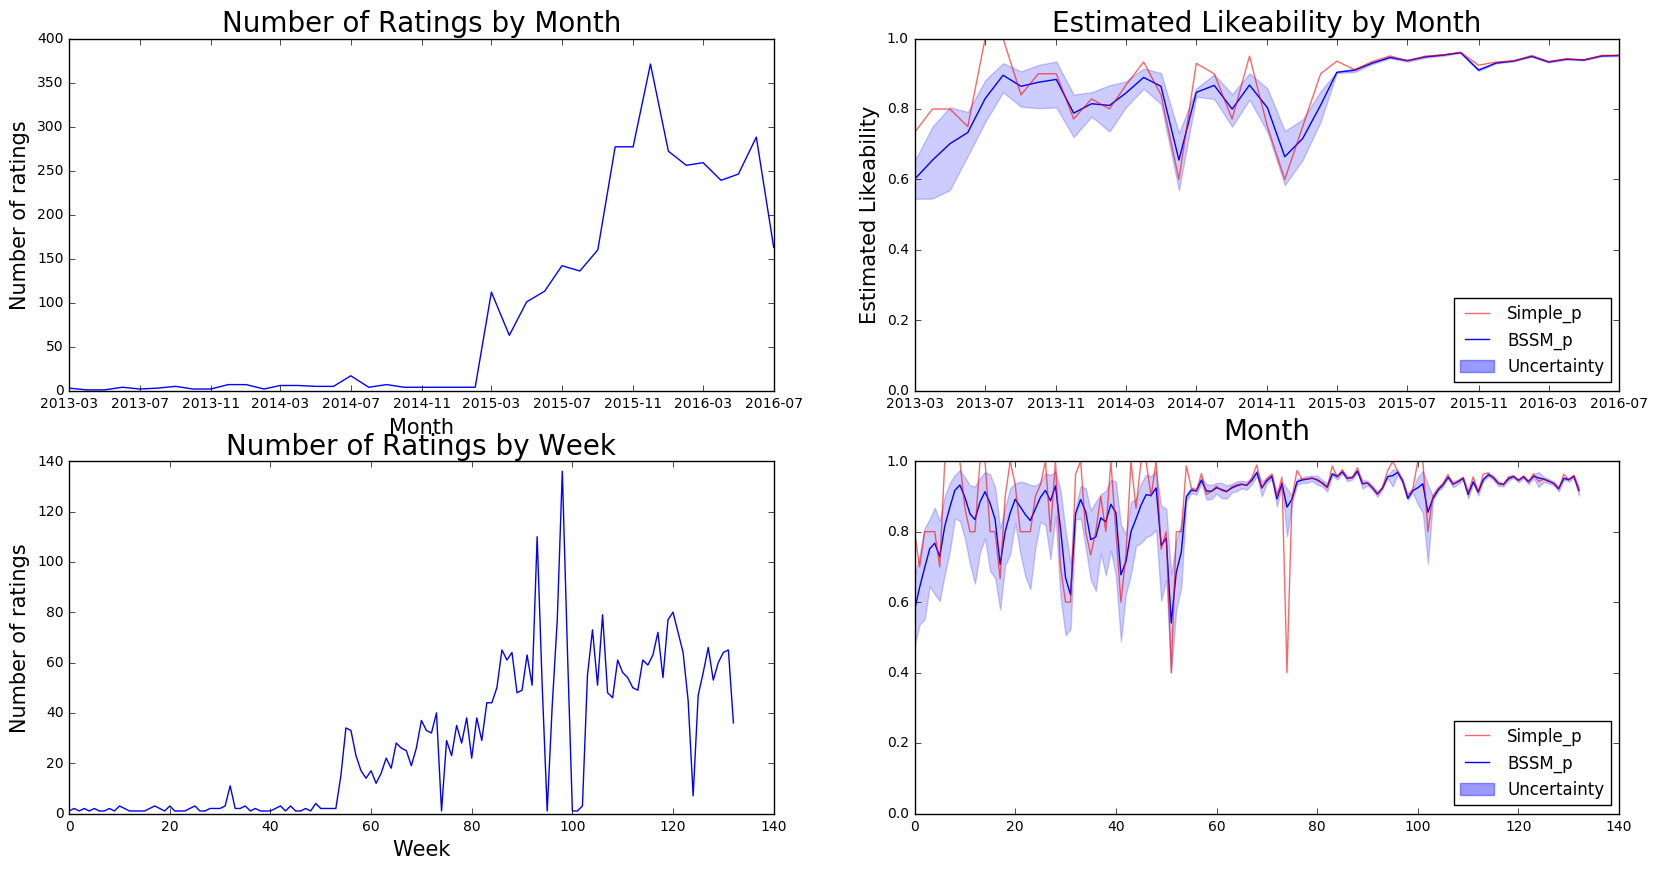

Serendipity 3


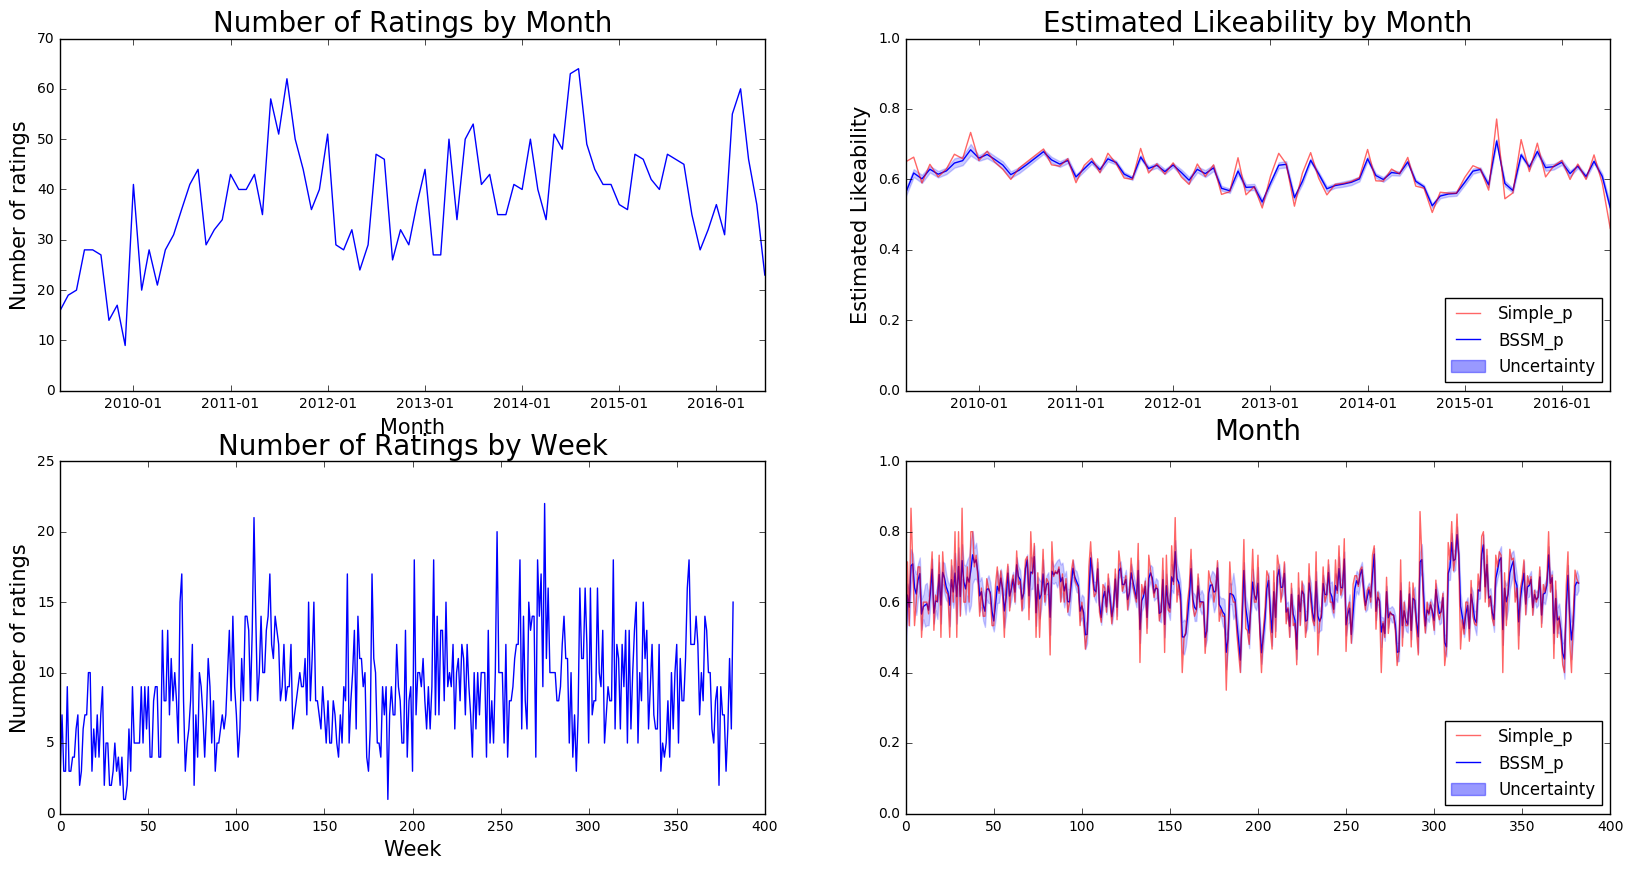

Hash House A Go Go


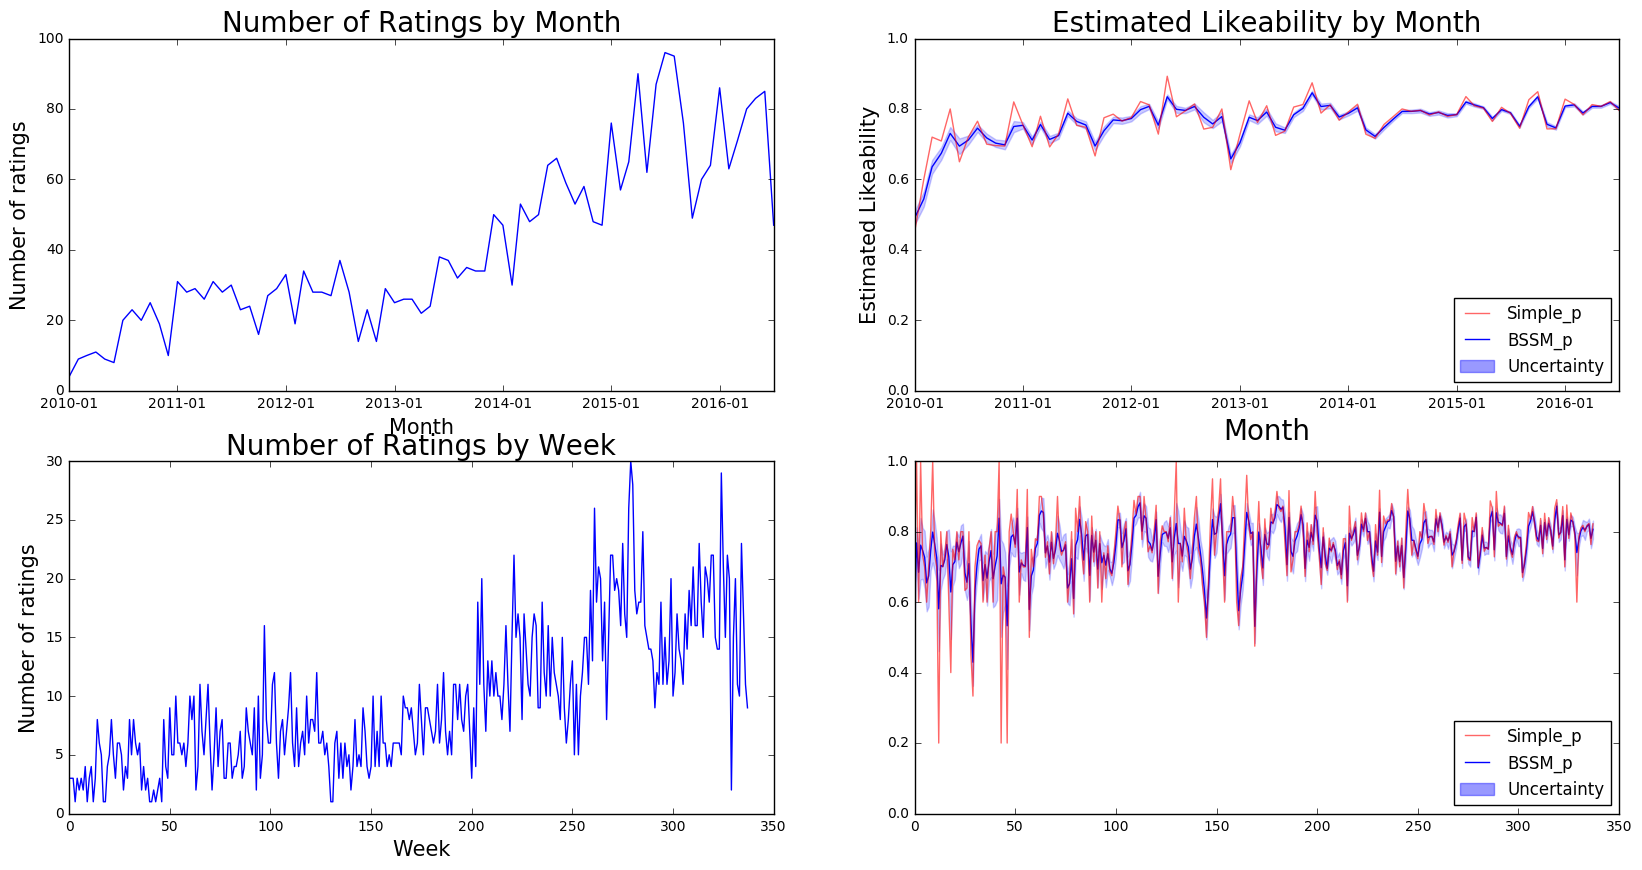

The Buffet


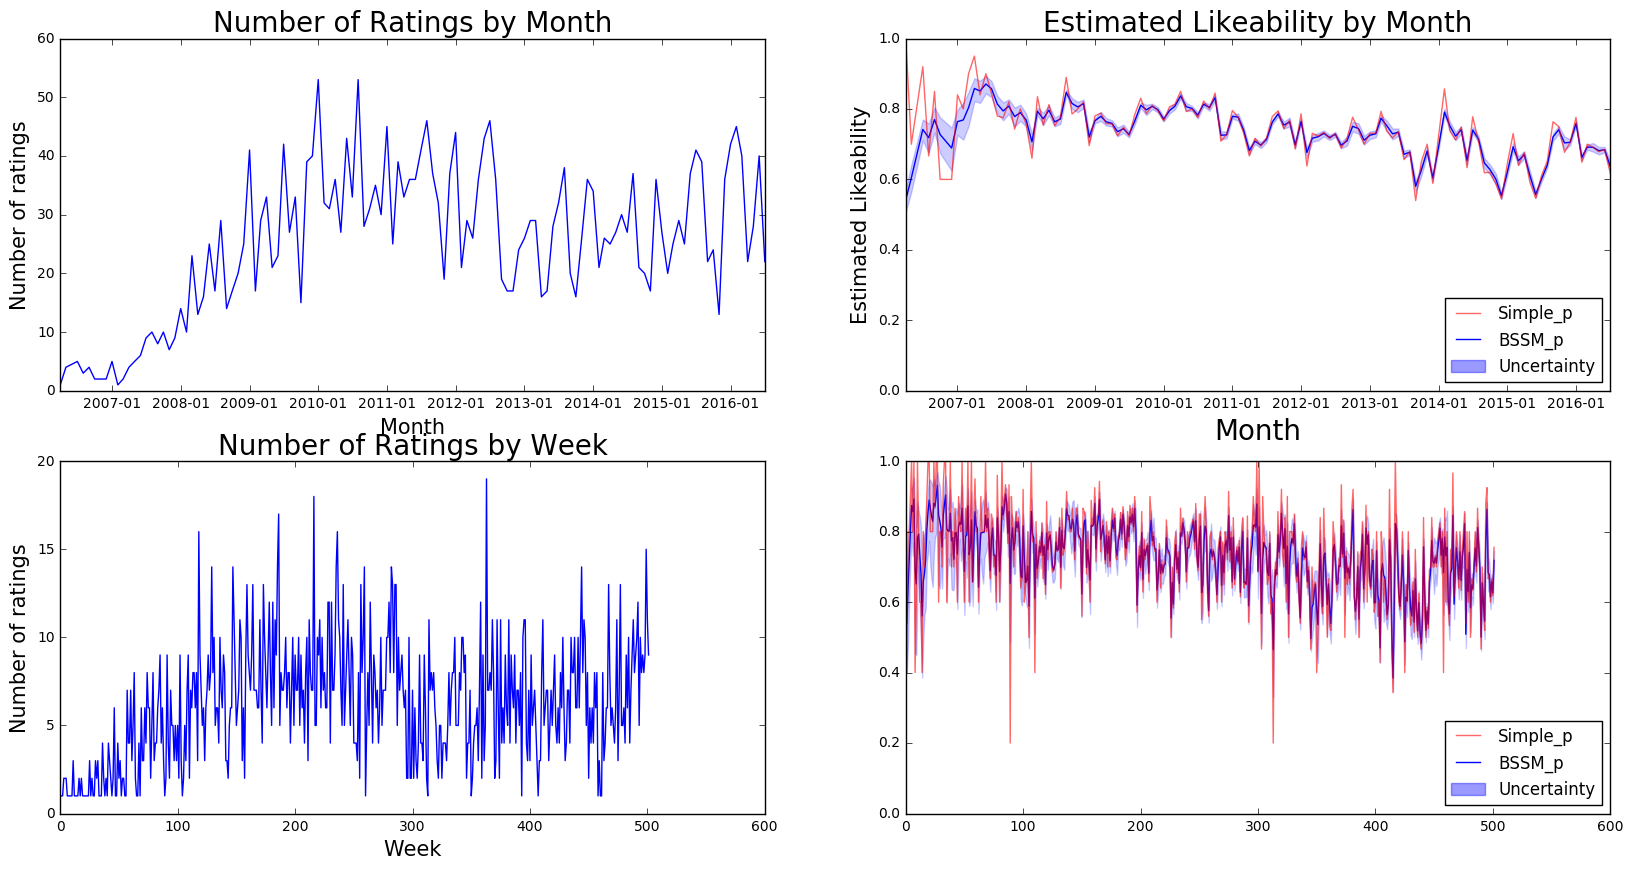

Lotus of Siam


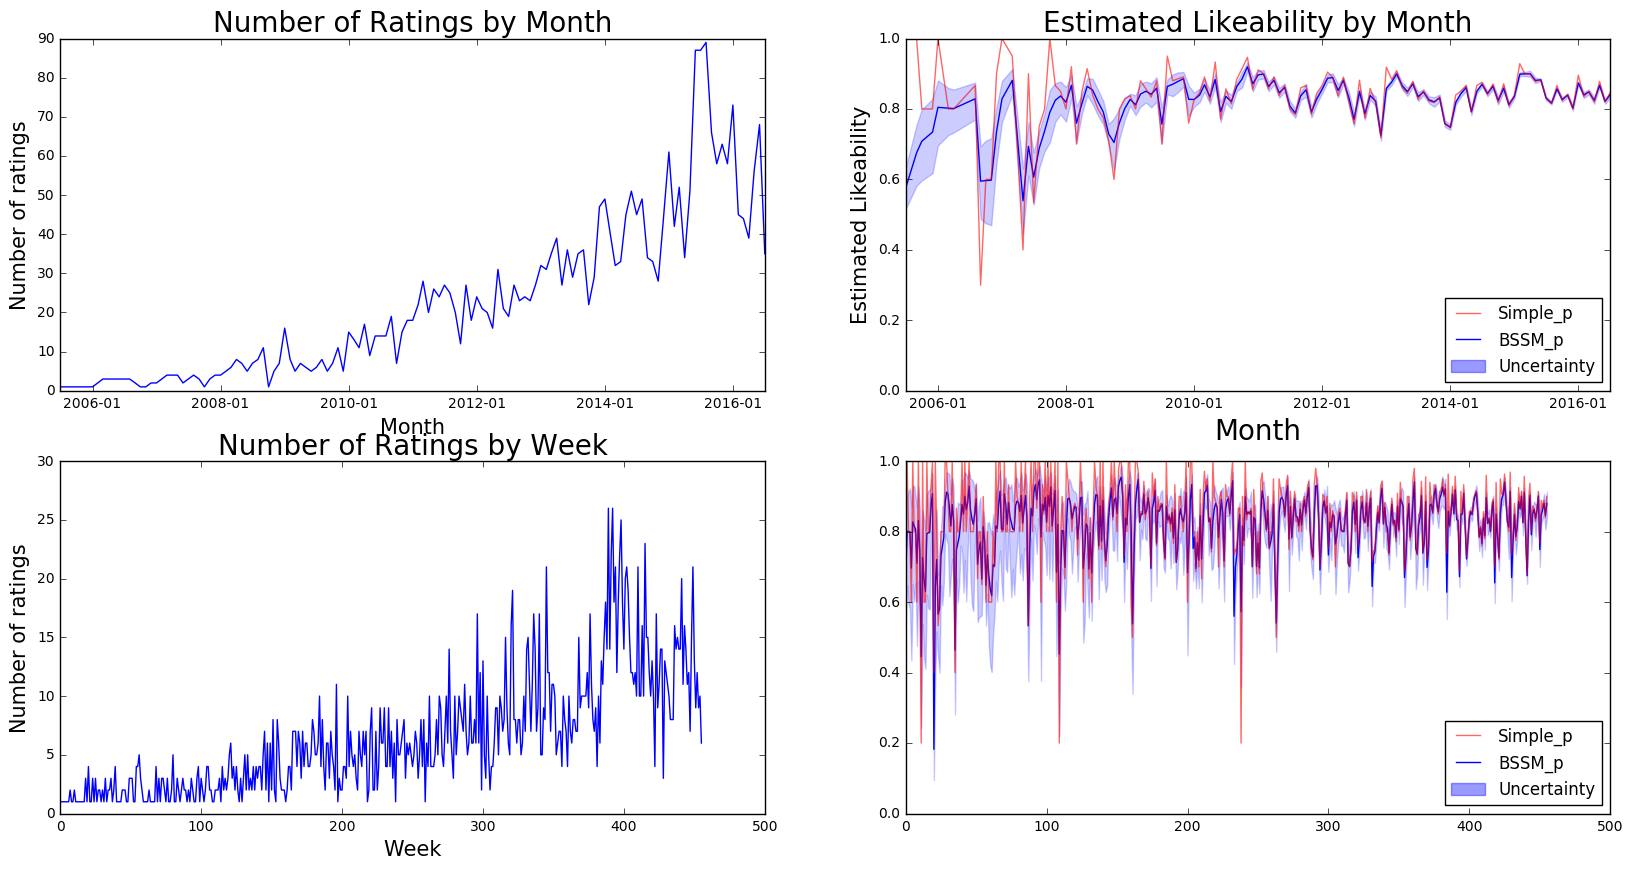

In [239]:
for i in range(10):
    ID = num_review_tuple[i][0]
    res = Restuarant(ID,business,review)
    res.reviews_year_month()
    res.reviews_year_day()
    res.reviews_date()
    res.reviews_month()
    res.target['week'] = pd.to_datetime(res.target['date'], format = '%Y-%m-%d').map(kw).apply(str)
    res.target["year_week"] = res.target["year"].map(str) + res.target["week"]
    res.reviews_week()
    res.plot_reviews()
#     reviews = nreviews_year_month(ID,review,business)
#     plot_reviews(reviews[0],reviews[1])

## Future Work

- Give a ranking
- Visualize by week
- Seasonal effect: number of people by month (poisson)
